# <div align="center"><b> APSERa Final - Getting and Saving residuals </b></div>


In [33]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import ephem
from scipy.signal import correlate

from scipy.optimize import curve_fit

%matplotlib inline
from scipy.signal import savgol_filter
from pygsm import GlobalSkyModel
from ms_fit_joint_inf import ms_fit_inf, chisq_poly
import maxsmooth
from maxsmooth.DCF import smooth

from astropy.timeseries import TimeSeries, BinnedTimeSeries
from astropy.time import Time, TimeDelta
from astropy.coordinates import Galactic, SkyCoord, FK5, EarthLocation, AltAz, Angle
import astropy.units as u

import pandas as pd
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, RegularGridInterpolator



In [40]:
start_time_in_UTC = '2024-05-19 13:25:00.000'
n_spectra = 1                 #Number of spectra to be taken
delta_t_in_hours = 1            #Time interval between each spectra needed in hours

t = Time(start_time_in_UTC, format = 'iso', scale= 'utc')

ts = TimeSeries(time_start= start_time_in_UTC, time_delta= delta_t_in_hours *u.hour, n_samples= n_spectra)
ts = ts.time
print(ts)

['2024-05-19 13:25:00.000']


In [41]:
h = 6.62607157e-34
k = 1.3806488e-23
c = 2.99792458e+08
TCMB = 2.72548
f_start = 2.0
f_stop = 4.0
No_of_Channels = 201
Channel_width = 0.01
N_SIDE = 16
T_hot = 3730
T_cold = 2730                    #T_cold and T_hot in Kelvins
Time_in_UTC = ts
latitude = -26.7031
longitude = 116.6706            #Latitude and longitude in degrees
altitude = 0                     #Altitude in meters
alpha = 0.0065                   #Temp. lapse rate (deg C per meter)
PI = 3.14159265
Noise_int_time = 3e+12
Trx = 14
T_atm = 1
freqs = np.linspace(f_start,f_stop, No_of_Channels)
CMB_Int = np.empty([No_of_Channels])
P_hot = np.empty(No_of_Channels)
P_cold = np.empty(No_of_Channels)
P_dif = np.empty(No_of_Channels)
cross_real_with_sig = [0]*No_of_Channels
cross_real_no_sig = [0]*No_of_Channels
cross_imag_with_sig = [0]*No_of_Channels
cross_imag_no_sig = [0]*No_of_Channels
final_temp_with_sig = [0]*No_of_Channels
final_temp_no_sig = [0]*No_of_Channels
sumwt_with_sig = [0]*No_of_Channels
sumwt_no_sig = [0]*No_of_Channels
sigma = [0]*No_of_Channels
spectra_with_sig = [0]*n_spectra
spectra_no_sig = [0]*n_spectra
NPIX = hp.nside2npix(N_SIDE)


#Refraction correction formula
def refraction(alt_in_deg, altitude):
    pres = 1010.*math.pow((1-6.5/288000*altitude),5.255)
    if (altitude>11000):
        temp = 211.5
    else:
        temp = 283.0 - (alpha * altitude)
    R = 1.02/math.tan((alt_in_deg + (10.3/(alt_in_deg + 5.11)))*(PI/180))
    if (alt_in_deg == 90):
        R = R+ 0.0019279
    tpcor = (pres/1000) * (283/temp)
    R =  tpcor*(R/60)
    return alt_in_deg +R



Obs = ephem.Observer()
t = Time(Time_in_UTC, scale='utc',location= EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg, height=altitude*u.m))
lst = t.sidereal_time('apparent')
print(lst)

[13h02m30.68127575s]


## <div align="center"><b> Getting maps, calculating CMB intensity </b></div>


In [42]:
gsm = GlobalSkyModel(freq_unit='GHz')

CMB_Int = ((2*h*1e+27*freqs**3)/(c*c))/(np.exp((h*freqs*1e+9)/(k*TCMB))-1)
print("Got CMB Int!")

#P_hot and P_cold for calibration
P_hot = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_hot))-1)
P_cold = (2*h*freqs*1e9)/(np.exp((h*freqs*1e9)/(k*T_cold))-1)
P_dif = P_hot -P_cold

print("Got P_dif for calibration!")

sky_1420 = hp.ud_grade(np.loadtxt('1420MHz_Sky_map.txt') - TCMB, 16, order_in = "NESTED", order_out= "RING")

sky_408 = hp.ud_grade(((np.loadtxt('408MHz_Sky_map.txt'))/1000) - TCMB, 16, order_in = "NESTED", order_out= "RING")

sky_23000 = hp.ud_grade((np.loadtxt('23000MHz_Sky_map.txt')/1000), 16, order_in = "NESTED", order_out= "RING")

print("Got 408MHz, 1420MHz and 23000MHz maps for power law fitting!")

Got CMB Int!
Got P_dif for calibration!
Got 408MHz, 1420MHz and 23000MHz maps for power law fitting!


## <div align="center"><b> Getting recombination lines </b></div>


/tmp/ipykernel_5921/115827261.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(r'total_spec_new.txt',sep= "    " ,header = None)


<IPython.core.display.Javascript object>


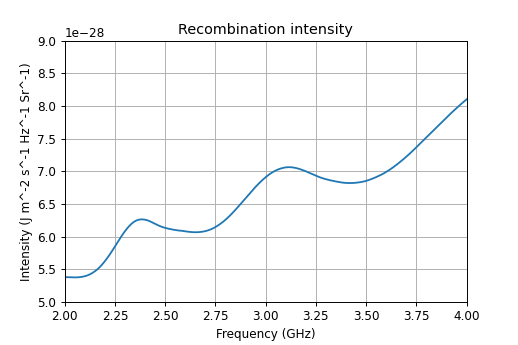

In [43]:
%matplotlib notebook
#/home/dhashin/workspace/APSERa/

df = pd.read_csv(r'total_spec_new.txt',sep= "    " ,header = None)
df.reset_index(drop=True, inplace=True)
df.columns = ["Frequency","Intensity"]

x = df["Frequency"]
y= df["Intensity"]

plt.plot((df['Frequency']), (df['Intensity']))
plt.title('Recombination intensity')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Intensity (J m^-2 s^-1 Hz^-1 Sr^-1)')
plt.xlim([f_start,f_stop])
plt.ylim([0.5e-27,0.9e-27])
plt.grid()
plt.show()

ius = InterpolatedUnivariateSpline(x, y)
Rec_int = ius(freqs)



Working for 1d total wobble: 0.0 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


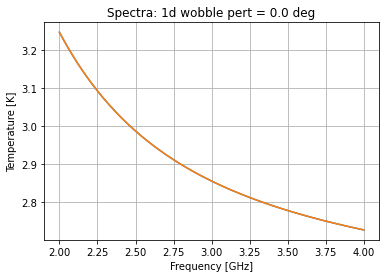

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201


/tmp/ipykernel_5921/1517745540.py:472: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq1 =  1.4089930393271876e-05
2.72630019746919 -0.245700218046974 -2.564169044295068
 


/tmp/ipykernel_5921/1517745540.py:482: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq2 =  9.216272672795493e-09
2.7254817869093335 -0.24503935139019897 -2.5622155294121898 0.025493010921298586
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 310
         Function evaluations: 623
 
chisq3 =  7.65323309262574e-09
2.7254790730743226 -0.24503729344300812 -2.562202158119253 0.025510136404523164 0.0001642462992073727
 


/tmp/ipykernel_5921/1517745540.py:502: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq4 =  7.617038861563361e-09
2.7254804885199073 -0.2450383744505369 -2.562208473111403 0.025489621370600995 0.00014558773952375286 -0.00012090627138850929
 


/tmp/ipykernel_5921/1517745540.py:512: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq5 =  7.61649552757581e-09
2.7254804412989384 -0.2450383386524164 -2.5622082391698866 0.02548990433941076 0.00014848471644932554 -0.00012090628399731579 1.119526763040386e-09
 


/tmp/ipykernel_5921/1517745540.py:522: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq6 =  7.616495180998246e-09
2.725480441281891 -0.24503833863935465 -2.562208239102557 0.02548990479535705 0.00014848475333420526 -0.00012090628399604978 1.1195296034387298e-09 2.6876126974896603e-13
 


/tmp/ipykernel_5921/1517745540.py:532: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq7 =  7.616495166941564e-09
2.725480441281891 -0.24503833863935465 -2.562208239102557 0.02548990479535879 0.00014848475421923323 -0.00012090628399604978 1.1196935970329834e-09 2.6876126974896603e-13 0.0
 


/tmp/ipykernel_5921/1517745540.py:542: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq8 =  7.616495163674728e-09
2.725480441281891 -0.24503833863935462 -2.562208239102557 0.025489904795358908 0.00014848475423305925 -0.0001209062839960498 1.1196935970329888e-09 2.687612697489672e-13 -5.439152270671927e-19 2.0322719702478892e-20


/tmp/ipykernel_5921/1517745540.py:549: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq9 =  7.616495163457478e-09
2.725480441281891 -0.24503833863935462 -2.562208239102557 0.025489904795358908 0.00014848475423305925 -0.0001209062839960498 1.1197209333024476e-09 2.687612697489672e-13 -5.439152270671927e-19 2.0322719702478892e-20 0.0


/tmp/ipykernel_5921/1517745540.py:556: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq10 =  7.616495163457478e-09
2.725480441281891 -0.24503833863935462 -2.562208239102557 0.025489904795358908 0.00014848475423305925 -0.0001209062839960498 1.1197209333024476e-09 2.687612697489672e-13 -5.439152270671927e-19 2.0322719702478892e-20 0.0 0.0
 
[]
Limits in index:  0 200
201
201


/tmp/ipykernel_5921/1517745540.py:628: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq1 =  1.4092494202966065e-05
2.7263001689221045 -0.24570052807891646 -2.564169901470971
 


/tmp/ipykernel_5921/1517745540.py:638: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq2 =  5.428430801020776e-09
2.7254816084599356 -0.24503953986478114 -2.5622160271535654 0.02549768912673351
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 290
         Function evaluations: 614
 
chisq3 =  1.748226073577613e-10
2.725478740963965 -0.24503736539917764 -2.5622018986391986 0.02551578342565831 0.00017354856858542835
 


/tmp/ipykernel_5921/1517745540.py:658: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq4 =  2.22000419572887e-11
2.7254797802211073 -0.24503815930623776 -2.5622065175827844 0.025500416818058824 0.0001615678221527777 -9.18163304598016e-05
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 316
         Function evaluations: 730
 
chisq5 =  2.2200017729641535e-11
2.7254797802211073 -0.24503815930623596 -2.562206517582858 0.025500416819071357 0.00016156781836819157 -9.18163270122499e-05 -1.1425850293287591e-16
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 332
         Function evaluations: 764
 
chisq6 =  2.2200016156477622e-11
2.7254797802211073 -0.24503815930623601 -2.5622065175828617 0.025500416819073297 0.00016156781817159142 -9.181632622064441e-05 -1.142612930091664e-16 -3.6711055101699995e-18
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 381
         Function evaluations: 910
 
chisq7 =  2.220001615

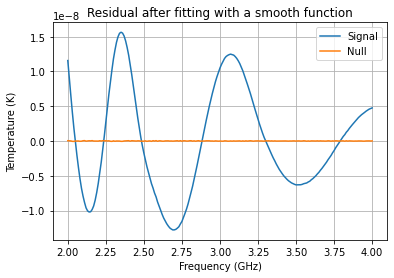

Working for 1d total wobble: 0.6 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


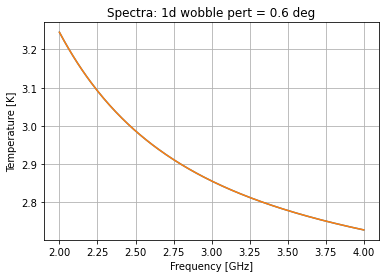

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 254
         Function evaluations: 499
 
chisq1 =  1.4881393945144733e-05
2.726318937406755 -0.24679474414787506 -2.5581928046339932
 
 
chisq2 =  1.0047714357580724e-08
2.725448012243661 -0.24609002583958534 -2.55610264115506 0.027007430288273203
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 287
         Function evaluations: 611
 
chisq3 =  8.250950420351975e-09
2.7254510768318037 -0.24609235559821652 -2.556117728379241 0.026987982869131923 -0.00018400598114153396
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 270
         Function evaluations: 618
 
chisq4 =  8.250949706412016e-09
2.725451077638396 -0.24609235620671271 -2.5561177327087634 0.026987980669173135 -0.0001840

/tmp/ipykernel_5921/1517745540.py:648: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq3 =  2.042255252190808e-09
2.7254507427976145 -0.246092426251823 -2.5561174588572344 0.026993668622779618 -0.00017473337112707828
 
 
chisq4 =  2.04225483332977e-09
2.7254507429516073 -0.2460924263715069 -2.556117459614524 0.026993667999257773 -0.0001747442281384034 -1.4728356247132728e-12
 


/tmp/ipykernel_5921/1517745540.py:668: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq5 =  2.04225483332977e-09
2.7254507429516073 -0.2460924263715069 -2.556117459614524 0.026993667999257773 -0.0001747442281384034 -1.4728356247132728e-12 0.0
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 124
         Function evaluations: 563
 
chisq6 =  2.0422547724290754e-09
2.7254507429516073 -0.24609242637150675 -2.55611745961452 0.026993668029430474 -0.00017474422817098396 -1.4728356247135418e-12 -2.2682449859166272e-18 -8.933549094865824e-19
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 368
         Function evaluations: 837
 
chisq7 =  2.042254771282831e-09
2.7254507429516073 -0.24609242637150675 -2.55611745961452 0.026993668029430443 -0.0001747442281684833 -1.4751234461695534e-12 -2.268251908059099e-18 -8.933576357926031e-19 -8.888544391360935e-20
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 345
        

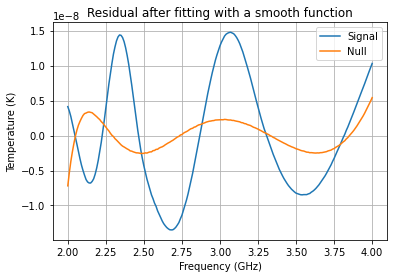

Working for 1d total wobble: 1.2 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


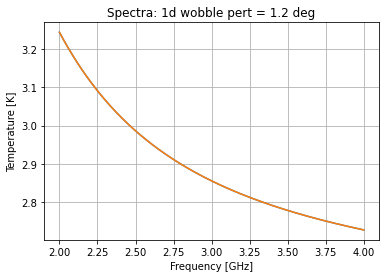

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  1.5662145265079344e-05
2.726340719100406 -0.24788924841806798 -2.552253915198713
 
 
chisq2 =  1.666634206132645e-08
2.725417185959767 -0.24714042231695074 -2.5500256063599664 0.028511488884787658
 


/tmp/ipykernel_5921/1517745540.py:492: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq3 =  9.065528111782288e-09
2.725424747009427 -0.2471461847458862 -2.550062801685149 0.028463253868716534 -0.000450415199118721
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 631
         Function evaluations: 1159
 
chisq4 =  7.657433387511412e-09
2.7254546096560675 -0.24716910858693392 -2.5501955881344855 0.028024770509740077 -0.0007970295633319311 -0.0025838643449818477
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 546
         Function evaluations: 1072
 
chisq5 =  7.644827574176402e-09
2.7254548898998214 -0.24716932232450528 -2.5501970176302766 0.02802571118519405 -0.0008509522311394744 -0.002400079019258714 -0.0002977090379346556
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 360
         Function evaluations: 828
 
chisq6 =  7.644824643634704e-09
2.725454890292668 -0.24716932263677718 -2.5501970183442735 0.

/tmp/ipykernel_5921/1517745540.py:678: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq6 =  1.796700812657411e-10
2.7254470388788175 -0.24716362403948886 -2.550163141930926 0.028136878068135154 -0.0007052381187112801 -0.0019519004285983624 -7.795846774150373e-06 8.136895402115177e-12
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 308
         Function evaluations: 778
 
chisq7 =  1.7967006861595653e-10
2.7254470388788175 -0.24716362403948877 -2.550163141930926 0.028136878068136265 -0.0007052381183870712 -0.00195190042873283 -7.795850355605184e-06 8.136917952255188e-12 -4.494951017264081e-19
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 115
         Function evaluations: 674
 
chisq8 =  1.796700681720109e-10
2.7254470388788175 -0.24716362403948877 -2.550163141930926 0.028136878068136265 -0.0007052381183880975 -0.00195190042873283 -7.795850355605184e-06 8.136917952255188e-12 -4.494951017264081e-19 0.0
Optimization terminated successfully.
         Current

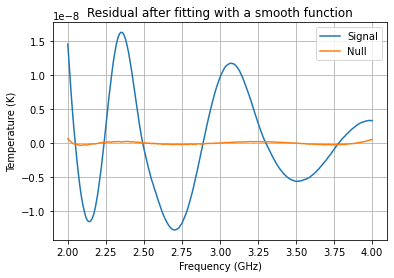

Working for 1d total wobble: 1.7999999999999998 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


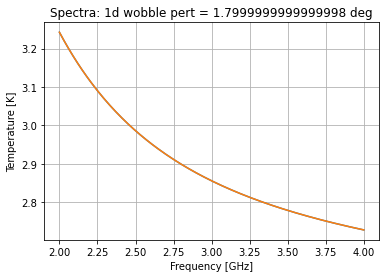

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  1.6446004301326976e-05
2.7263657006470834 -0.24898369315268348 -2.5463547041384795
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 287
         Function evaluations: 583
 
chisq2 =  2.1061883161155366e-08
2.725388646603888 -0.24818983635527564 -2.5439847586985023 0.03003039629575241
 
 
chisq3 =  9.912858939509937e-09
2.725398808695413 -0.2481976004361054 -2.5440347111949886 0.029965227068810732 -0.0006005848894528709
 
 
chisq4 =  7.709608401806963e-09
2.7254377066105597 -0.24822753249849588 -2.544207713531772 0.02939609571721995 -0.0010537637296307901 -0.0033295815629743744
 
 
chisq5 =  7.68753441402329e-09
2.7254393462174686 -0.24822879169933984 -2.5442153334185136 0.029381060177812425 -0.0011621759962438557 -0.0031048565872185976 -0.0005208038047647514
 
 
chisq6 =  7.648195614780437e-09
2.7254396731630717 -0.24

/tmp/ipykernel_5921/1517745540.py:688: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq7 =  2.5544256584319824e-10
2.7254299784780818 -0.2482219135408863 -2.5441745564075995 0.029510112537043456 -0.0009596179809306073 -0.0026918492465235295 -6.520678902404324e-06 -3.34749616719633e-19 -3.800127552416888e-19
 


/tmp/ipykernel_5921/1517745540.py:698: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq8 =  2.5544256584319824e-10
2.7254299784780818 -0.2482219135408863 -2.5441745564075995 0.029510112537043456 -0.0009596179809306073 -0.0026918492465235295 -6.520678902404324e-06 -3.34749616719633e-19 -3.800127552416888e-19 0.0


/tmp/ipykernel_5921/1517745540.py:705: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq9 =  2.5544255876569327e-10
2.7254299784780818 -0.2482219135408863 -2.5441745564075995 0.029510112537043623 -0.0009596179809306073 -0.0026918492465245088 -6.520678921835052e-06 -3.34749616719633e-19 -3.800127552416888e-19 0.0 0.0
 
chisq10 =  2.5544255876569327e-10
2.7254299784780818 -0.2482219135408863 -2.5441745564075995 0.029510112537043623 -0.0009596179809306073 -0.0026918492465245088 -6.520678921835052e-06 -3.34749616719633e-19 -3.800127552416888e-19 0.0 0.0 0.0
 
[]


/tmp/ipykernel_5921/1517745540.py:712: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


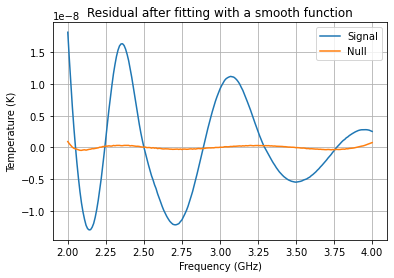

Working for 1d total wobble: 2.4 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


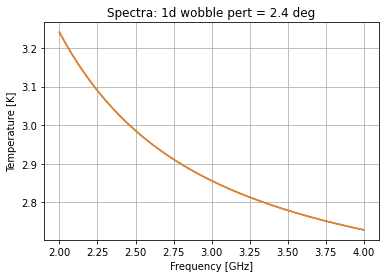

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 272
         Function evaluations: 527
 
chisq1 =  1.7246776168337525e-05
2.7263940416663 -0.2500780420790907 -2.540497514929976
 
 
chisq2 =  2.1344421356218453e-08
2.7253617087436512 -0.2492375398058247 -2.537980332930648 0.03158966917059912
 
 
chisq3 =  1.0663370046342908e-08
2.725371936847562 -0.24924537377786984 -2.53803057196414 0.03152373746846973 -0.0005996959103493525
 
 
chisq4 =  7.757099990486536e-09
2.7254182813237984 -0.24928112207593411 -2.538236739604688 0.030848073986373167 -0.0011417416877039911 -0.003923518195851449
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 476
         Function evaluations: 961
 
chisq5 =  7.752525843015704e-09
2.7254177004717075 -0.24928067357724293 -2.538234215885545 0.030858271366504

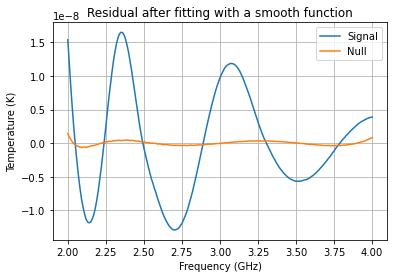

Working for 1d total wobble: 3.0 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


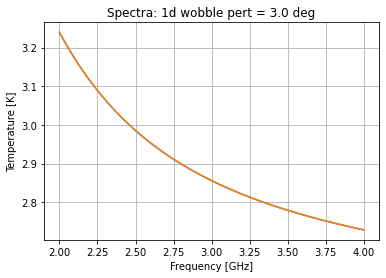

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  1.807824498407824e-05
2.7264259008328473 -0.25117226040932417 -2.5346846654507407
 
 
chisq2 =  1.6922360275423516e-08
2.725335663163608 -0.2502827807965559 -2.5320124637554704 0.03321511298678356
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 324
         Function evaluations: 652
 
chisq3 =  1.122763586264523e-08
2.7253427487975386 -0.25028822133738127 -2.5320472404606917 0.03316919613125799 -0.00041210570620281304
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 615
         Function evaluations: 1160
 
chisq4 =  7.800978711120015e-09
2.7253946784299803 -0.25032837393408025 -2.532278306230621 0.03241488976813668 -0.0010221510787260333 -0.004346514765728123
 
 
chisq5 =  7.800661271903637e-09
2.7253946697940488 -0.2503283674266171 -2.5322782547814735 0.03241483

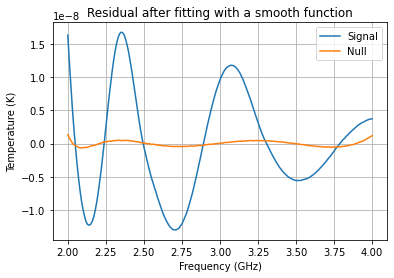

Working for 1d total wobble: 3.5999999999999996 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


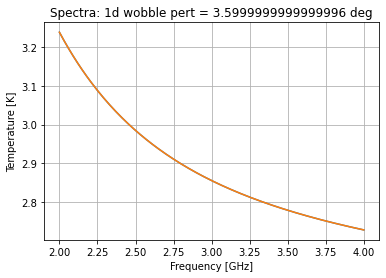

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  1.8954167736248775e-05
2.7264614426228184 -0.25226631820045403 -2.5289185299279726
 
 
chisq2 =  1.1543050451285253e-08
2.7253097760155796 -0.2513247829099631 -2.5260811812795785 0.03493282984691803
 
 
chisq3 =  1.1542957908259702e-08
2.725309800517363 -0.25132480176296623 -2.5260813016695223 0.03493267168026772 -1.4156870687146988e-06
 
 
chisq4 =  1.1542957901203132e-08
2.725309800517363 -0.2513248017629663 -2.526081301669522 0.03493267168026516 -1.415687069430504e-06 1.0898261455793356e-18
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 277
         Function evaluations: 690
 
chisq5 =  1.15429578916205e-08
2.725309800517363 -0.25132480176296623 -2.526081301669521 0.03493267168026465 -1.4156871067616066e-06 1.0898261778744128e-18 -1.7029516914376714e-19
 
Optimization terminated successfully.
         Current fun

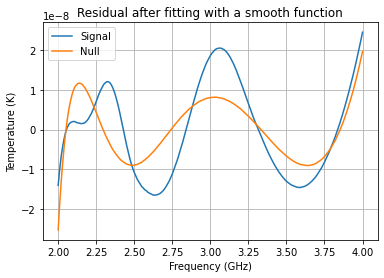

Working for 1d total wobble: 4.2 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


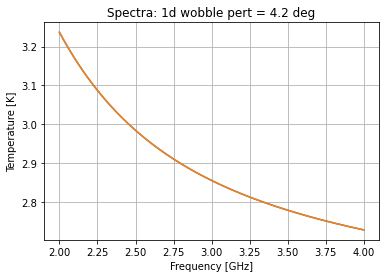

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  1.9888268003518758e-05
2.7265008291852104 -0.2533601858036235 -2.5232014471349538
 
 
chisq2 =  2.346404111036133e-08
2.7252832898121744 -0.25236274587788454 -2.520186410967317 0.03676917333241267
 
 
chisq3 =  1.1566923718435527e-08
2.7252715844867086 -0.25235371381495314 -2.520129054107821 0.03684585949498882 0.0006695746771752008
 
 
chisq4 =  1.0980195210396561e-08
2.725277909596185 -0.25235862483320376 -2.520157431630743 0.03675865372127239 0.0005715415564819694 -0.00047465484803458534
 
 
chisq5 =  1.0977457324646404e-08
2.7252778804319333 -0.2523586018143866 -2.520157316048458 0.03675908327201039 0.0005727956428086488 -0.0004746548805498292 -1.383244139416314e-06
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 573
         Function evaluations: 1165
 
chisq6 =  1.094461783537648e-08
2.7252774178464163 -0.25235

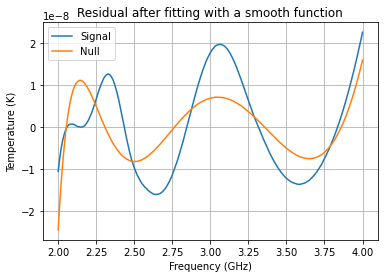

Working for 1d total wobble: 4.8 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


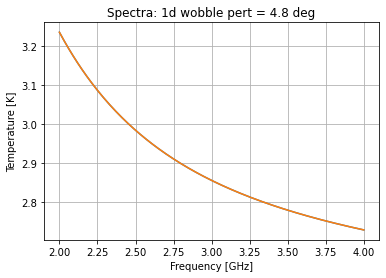

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  2.0894229399331118e-05
2.726544226300673 -0.2544538371417939 -2.517535787988288
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 255
         Function evaluations: 546
 
chisq2 =  5.10545414714395e-08
2.7252554211465023 -0.25339584364246825 -2.5143279646213195 0.03875079056962832
 
 
chisq3 =  1.1277930246436165e-08
2.7252265097997275 -0.2533734805308163 -2.5141864171427204 0.03894125459668889 0.0016396867561672118
 
 
chisq4 =  9.928736754564808e-09
2.725241896129246 -0.2533854579209831 -2.5142552201878057 0.03872580029514028 0.001424667410586911 -0.001183157417289912
 
 
chisq5 =  9.857910628355996e-09
2.725241373914737 -0.25338505473770856 -2.5142526075577654 0.038728324326999096 0.0014583134730033792 -0.0011831585008609431 -1.7895292160329665e-05
 
 
chisq6 =  9.75664531792211e-09
2.725234328910665 -0.253379572980

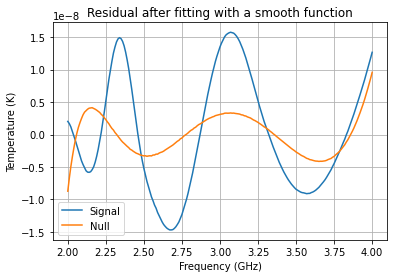

Working for 1d total wobble: 5.3999999999999995 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


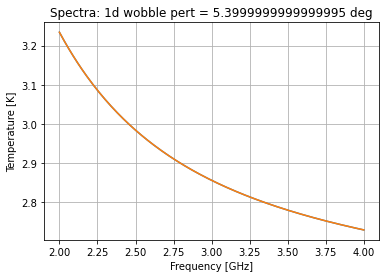

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  2.1985688533503003e-05
2.7265918003074403 -0.2555472485901076 -2.5119239197891967
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 275
         Function evaluations: 554
 
chisq2 =  8.981093851182609e-08
2.725225361173338 -0.25442322463301137 -2.5085055393801836 0.04090458775595095
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 377
         Function evaluations: 740
 
chisq3 =  1.0684027529252158e-08
2.7251729131604705 -0.25438255728059267 -2.5082489868993054 0.04125210085327613 0.0029483897787717407
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 934
         Function evaluations: 1632
 
chisq4 =  8.580823338612484e-09
2.7252000942359436 -0.2544037722909185 -2.50836998341841 0.040862990246164604 0.0026248962

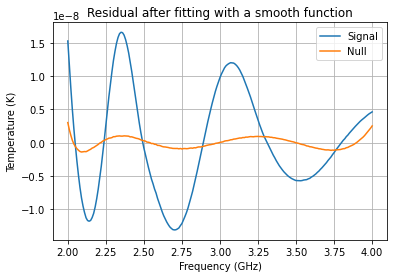

Working for 1d total wobble: 6.0 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


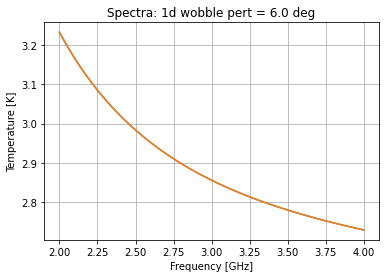

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 245
         Function evaluations: 490
 
chisq1 =  2.3176227442466275e-05
2.7266437167713904 -0.2566403973696533 -2.506368196675096
 
 
chisq2 =  1.4000052570742835e-07
2.7251922738829073 -0.2554440102504313 -2.5027187096895323 0.04325775013374203
 
 
chisq3 =  9.84624383696327e-09
2.7251090195983676 -0.2553793008427217 -2.502311847287497 0.04381266176548505 0.004637664510251302
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 635
         Function evaluations: 1146
 
chisq4 =  8.033275353716082e-09
2.7251491203984455 -0.2554106709720563 -2.502490433854117 0.04324183711543896 0.004152800390121681 -0.003142631375249151
 
 
chisq5 =  8.022027470827174e-09
2.725149150548572 -0.25541069346950573 -2.502490718313697 0.04324568085317829 

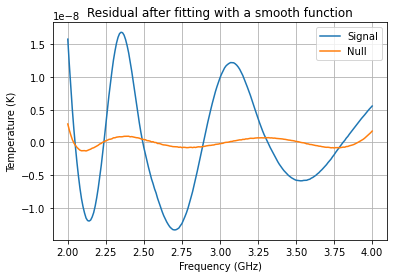

Working for 1d total wobble: 6.6 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


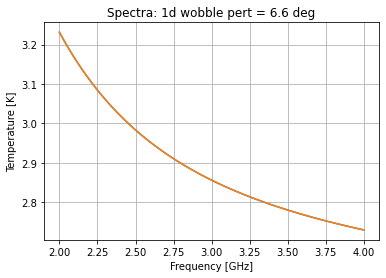

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  2.447936539105377e-05
2.726700147026705 -0.25773326636549815 -2.5008710213679777
 
 
chisq2 =  2.0254906734118185e-07
2.725155295209734 -0.25645729427121466 -2.496966919145128 0.04583772794041378
 
 
chisq3 =  8.930708405493325e-09
2.725032958066894 -0.2563619809312072 -2.4963696530400634 0.046658176240507984 0.00675054792733718
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 502
         Function evaluations: 968
 
chisq4 =  8.108195598838534e-09
2.725059922176995 -0.256383121764564 -2.4964897472508705 0.04627611764160432 0.0064219644900018 -0.0020799957003005045
 
 
chisq5 =  7.87467447518804e-09
2.725090873369939 -0.25640737559133214 -2.4966294697163294 0.04588787279210624 0.005546418717500789 -0.00244697612398209 -0.002869108794126241
 
 
chisq6 =  7.852850160466846e-09
2.725087757102446 -0.25640493478689375 -2.4

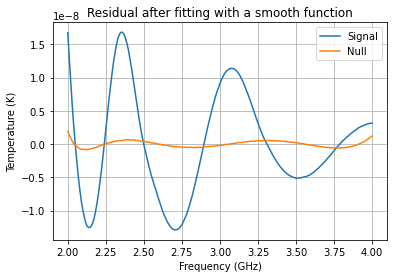

Working for 1d total wobble: 7.199999999999999 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


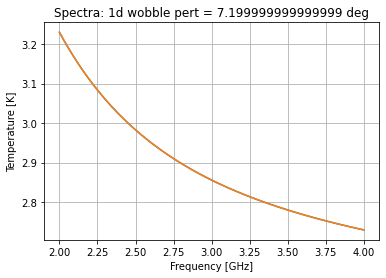

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  2.5908550106616204e-05
2.7267612562732215 -0.2588258362636834 -2.495434729149393
 
 
chisq2 =  2.785279314635015e-07
2.7251135313164787 -0.2574621411700911 -2.4912494742021454 0.048672256419078096
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 426
         Function evaluations: 811
 
chisq3 =  8.300420744211108e-09
2.7249427240037387 -0.25732875059523463 -2.490416452109047 0.049825132350497466 0.009332664798071193
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 519
         Function evaluations: 985
 
chisq4 =  8.208068402177709e-09
2.724951836144236 -0.2573359105499434 -2.490457039084152 0.04969665901308522 0.009220616441406732 -0.000690980780475321
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 567
      

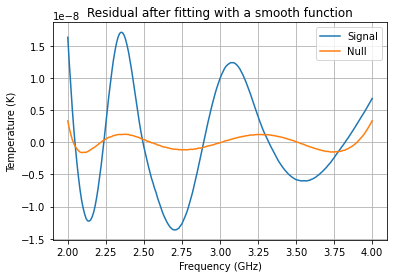

Working for 1d total wobble: 7.8 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


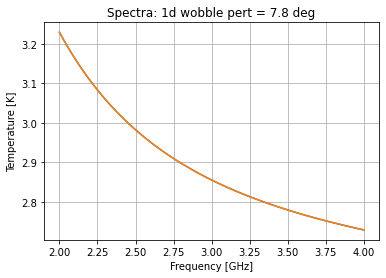

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  2.747714852475797e-05
2.7268272164414165 -0.2599180940110575 -2.490061720602251
 
 
chisq2 =  3.690674440026969e-07
2.725066057994349 -0.2584575856979512 -2.4855655381382094 0.05178932846166106
 
 
chisq3 =  8.547608637176274e-09
2.7248361691116614 -0.2582776374963157 -2.4844456471897765 0.05335141577616641 0.012431976808773412
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 311
         Function evaluations: 677
 
chisq4 =  8.541376198017405e-09
2.724835535342641 -0.25827713946020114 -2.484442738344721 0.05335883765849973 0.012448160921630088 3.2431562784574776e-05
 
 
chisq5 =  8.318590149276391e-09
2.724825033772163 -0.2582688674857505 -2.484396240515059 0.05351289697549179 0.012517504038520269 0.0010442649236528478 -0.0003064149219757947
 
 
chisq6 =  8.31854382882264e-09
2.7248250363011053 -0.25826886948022054 -

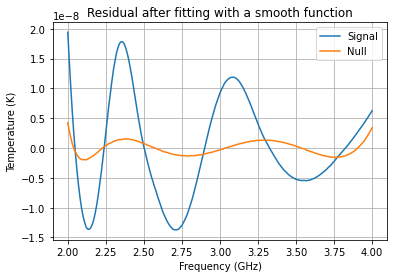

Working for 1d total wobble: 8.4 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


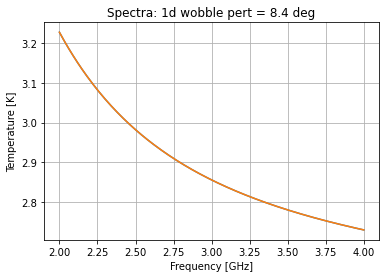

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  2.9198437200916126e-05
2.7268981976332722 -0.2610100265422235 -2.4847543678163677
 
 
chisq2 =  4.753359601245415e-07
2.7250119149233347 -0.25944262838747006 -2.4799141058067757 0.05521729463361925
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 353
         Function evaluations: 718
 
chisq3 =  1.0171567924583778e-08
2.7247109709187525 -0.2592065195026454 -2.4784498576897214 0.057276568621126525 0.016099572054463385
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 571
         Function evaluations: 1095
 
chisq4 =  8.530626317829715e-09
2.7246677104002517 -0.2591723823697867 -2.478257176548187 0.05788005509515182 0.01664203650148814 0.0031575318576045025
 
 
chisq5 =  8.370964391260504e-09
2.7246903592051464 -0.25919024477486885 -2.478359273281884 0.0575972575379

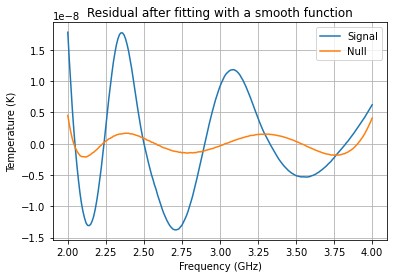

Working for 1d total wobble: 9.0 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


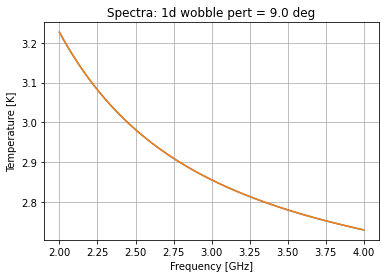

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  3.108559257146508e-05
2.7269743687208123 -0.2621016234713351 -2.479515027075456
 
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 281
         Function evaluations: 576
 
chisq2 =  5.985344036544835e-07
2.7249501090351673 -0.26041623799539293 -2.474294014413017 0.05898473504876624
 
 
chisq3 =  1.3185991437597947e-08
2.7245646025648176 -0.2601131001878106 -2.4724207886439578 0.06164209283144044 0.020390142487642576
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 569
         Function evaluations: 1060
 
chisq4 =  8.78666559924315e-09
2.7244853009832477 -0.26005039508149574 -2.4720676181592927 0.06274186460445799 0.021395907946730568 0.005663985986656416
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1043
     

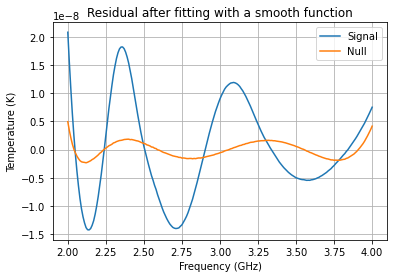

Working for 1d total wobble: 9.6 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


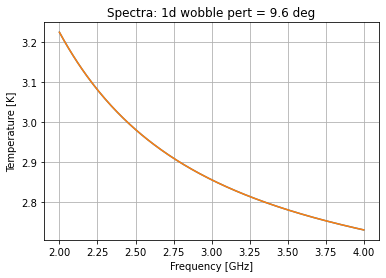

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  3.315168122860348e-05
2.7270559010492588 -0.2631928767225312 -2.4743460739231407
 
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 276
         Function evaluations: 552
 
chisq2 =  7.398955729049844e-07
2.724879606971742 -0.26137734554669856 -2.4687039111066547 0.06312058706702685
 
 
chisq3 =  1.7337548895567258e-08
2.724394300266881 -0.2609948824881638 -2.466349090012154 0.06649176160765886 0.02536240120260894
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 583
         Function evaluations: 1077
 
chisq4 =  9.136167280988194e-09
2.7242710917623176 -0.26089726690056303 -2.465800477788828 0.06818974191597696 0.026944383925965154 0.008594014286887983
 
 
chisq5 =  9.129385975686352e-09
2.724275912301016 -0.26090108531398926 -2.465822006373049 0.06812554067541979 0

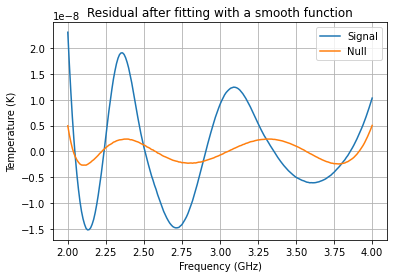

Working for 1d total wobble: 10.2 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


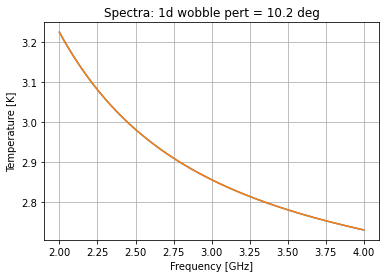

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  3.5409650396949594e-05
2.7271429651729053 -0.264283779586068 -2.4692498783699897
 
 
chisq2 =  9.00685261965483e-07
2.7247993309931893 -0.26232484116675575 -2.463142233909527 0.06765418493022224
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 412
         Function evaluations: 827
 
chisq3 =  2.241248831182545e-08
2.724197004708194 -0.26184912146788286 -2.4602241035101136 0.07187221676236086 0.031080333535181106
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 713
         Function evaluations: 1306
 
chisq4 =  9.609192765698058e-09
2.724020808493526 -0.2617092591687018 -2.459439755663726 0.07428411830860362 0.03337287244092098 0.011975490526757789
 
 
chisq5 =  9.608462634748603e-09
2.7240210122497626 -0.2617094212046594 -2.4594406400970237 0.07428107168675518 0.

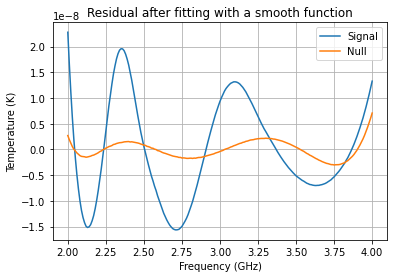

Working for 1d total wobble: 10.799999999999999 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


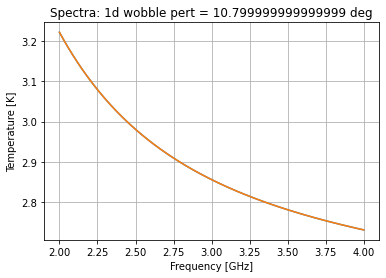

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000038
         Iterations: 263
         Function evaluations: 525
 
chisq1 =  3.7872318698521925e-05
2.7272357330957773 -0.26537432942361205 -2.4642288111607638
 
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 252
         Function evaluations: 529
 
chisq2 =  1.0822041962679302e-06
2.7247081611012334 -0.26325757554068085 -2.4576072164871707 0.07261514300930526
 
 
chisq3 =  2.828374751248858e-08
2.723969320593602 -0.26267279159046164 -2.4540336881569393 0.07783332016749804 0.03761344408505825
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 758
         Function evaluations: 1353
 
chisq4 =  1.024227802581894e-08
2.7237294844897697 -0.26248206603359825 -2.4529664234031285 0.08109263655659568 0.040778885

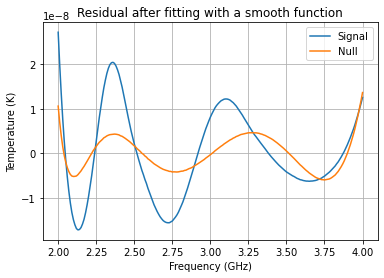

Working for 1d total wobble: 11.4 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


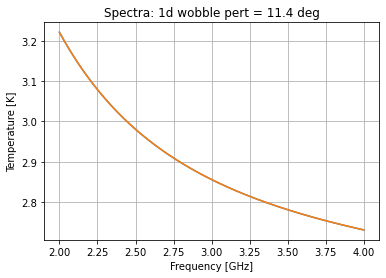

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000041
         Iterations: 274
         Function evaluations: 543
 
chisq1 =  4.0552367323050876e-05
2.727334372304097 -0.2664645214455956 -2.459285206680269
 
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 295
         Function evaluations: 591
 
chisq2 =  1.285790398750544e-06
2.7246049223775404 -0.2641743501238657 -2.4520968388417757 0.07803359328844969
 
 
chisq3 =  3.4878154259482686e-08
2.7237074220584567 -0.26346251060453435 -2.4477638144491003 0.08442912339244867 0.04503875848278527
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 641
         Function evaluations: 1210
 
chisq4 =  1.1078200684159929e-08
2.7233910626868423 -0.2632104961214424 -2.446356680051161 0.08869483966168942 0.0492785188889

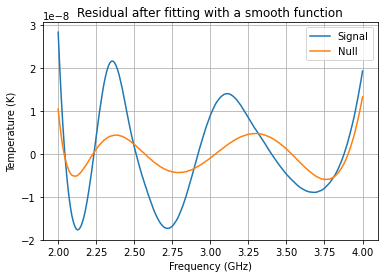

Working for 1d total wobble: 12.0 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


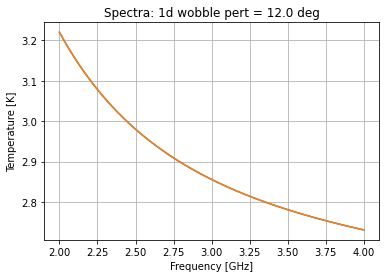

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000043
         Iterations: 253
         Function evaluations: 504
 
chisq1 =  4.346233160472652e-05
2.727439053573303 -0.2675543559806707 -2.4544214223520093
 
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 262
         Function evaluations: 528
 
chisq2 =  1.5128218581831986e-06
2.72448838972375 -0.26507392049743994 -2.4466088349393464 0.0839399476272973
 
 
chisq3 =  4.215144630799377e-08
2.7234069621933292 -0.2642144666970099 -2.441398176270231 0.0917187197602995 0.05344219074516924
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 806
         Function evaluations: 1453
 
chisq4 =  1.2164812777395217e-08
2.722998609917777 -0.2638886407262525 -2.439582953586913 0.09717845896570793 0.05900431800609249 0

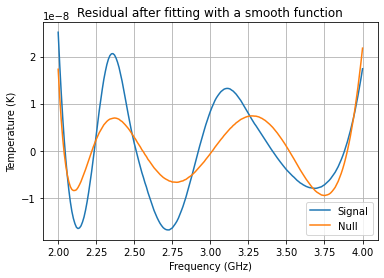

Working for 1d total wobble: 12.6 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


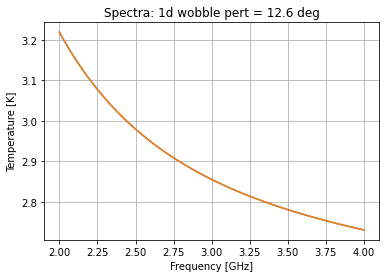

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  4.661459302899502e-05
2.7275499450223775 -0.26864383319259794 -2.449639791493659
 
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 248
         Function evaluations: 536
 
chisq2 =  1.7647194236243226e-06
2.72435726999972 -0.2659549825924973 -2.4411406291139857 0.09036528616188969
 
 
chisq3 =  5.0076979252369836e-08
2.723062957732951 -0.2649243256599428 -2.434917705866138 0.09976740339220261 0.06292004756130148
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 852
         Function evaluations: 1520
 
chisq4 =  1.3553003134020046e-08
2.722542823736902 -0.2645086820495792 -2.4326073242173365 0.10665807325817511 0.07012791590859088 0.03092356484142289
 
 
chisq5 =  1.3401051119866533e-08
2.722588978457697 -0.2645455286498847 -2.4328146837623836 0.10611546020304925 0.0

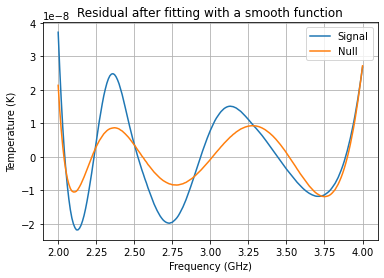

Working for 1d total wobble: 13.2 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


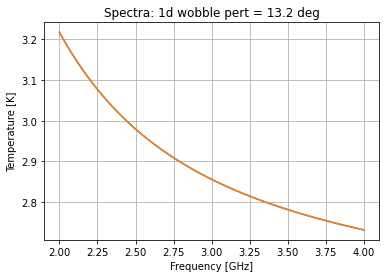

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  5.002137162968697e-05
2.7276672172251772 -0.269732957551935 -2.4449426694146803
 
 
chisq2 =  2.042949931238465e-06
2.724210206519202 -0.2668161759010287 -2.4356893407891183 0.09734107819225274
 
 
chisq3 =  5.8642978705824075e-08
2.7226695962240686 -0.2655870761067015 -2.428299746894034 0.10864853444112971 0.07358285537328711
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 979
         Function evaluations: 1712
 
chisq4 =  1.529354338751865e-08
2.7220119233114968 -0.26506080112528907 -2.425381160699934 0.11727448694533082 0.08286407561199616 0.03742957203266388
 
 
chisq5 =  1.5293102005708072e-08
2.7220120826938885 -0.2650609288731541 -2.425381844703269 0.11727209078749176 0.08286273232678758 0.037423624774085576 -1.1527322872218351e-05
 
Optimization terminated successfully.
         Current function value: 0.000

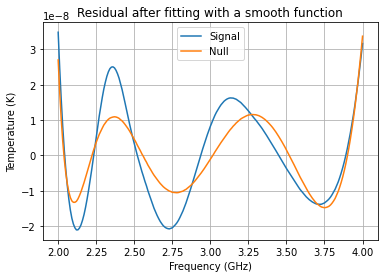

Working for 1d total wobble: 13.799999999999999 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


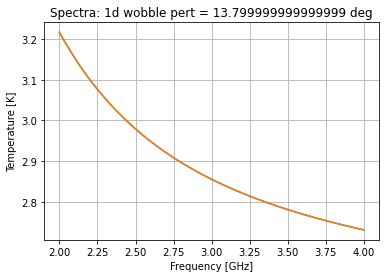

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000054
         Iterations: 230
         Function evaluations: 464
 
chisq1 =  5.3694718744048203e-05
2.7277910341685336 -0.2708217310816182 -2.440332346866585
 
 
chisq2 =  2.3490295503547663e-06
2.7240457590902447 -0.26765606747339815 -2.4302517168688906 0.10489960168092236
 
 
chisq3 =  6.785531539052872e-08
2.7222200324972095 -0.2661968661159541 -2.4215172020433275 0.1184455531048268 0.08555792020576392
 
 
chisq4 =  1.7432401342063736e-08
2.7213895617758426 -0.26553150712775 -2.41783604022095 0.12921894155174682 0.09750502113238474 0.04498254894325669
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 370
         Function evaluations: 789
 
chisq5 =  1.743148489830871e-08
2.72138953598 -0.265531486896744 -2.4178358973754213 0.1292189539838033 0.097505266

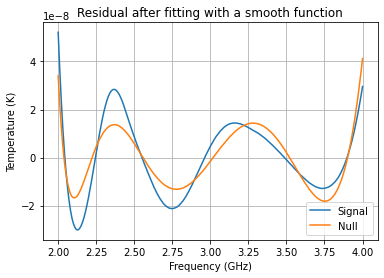

Working for 1d total wobble: 14.399999999999999 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


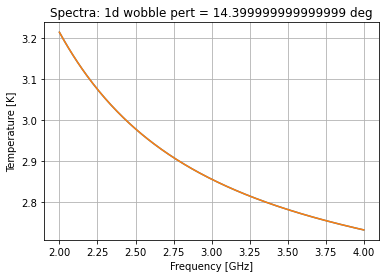

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  5.764651006123649e-05
2.727921563629369 -0.2719101596165516 -2.43581115813665
 
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 275
         Function evaluations: 565
 
chisq2 =  2.6845274094573708e-06
2.7238624113178145 -0.2684731586659961 -2.4248241278526086 0.11307350598682214
 
 
chisq3 =  7.774489182500958e-08
2.721706059357438 -0.2667467393007082 -2.414537143538901 0.12925523252312693 0.09899488842258505
 
 
chisq4 =  2.000208649031512e-08
2.7206516143621164 -0.2659010651026542 -2.409869863668321 0.14276899806919963 0.11447533553552613 0.053963612495726676
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 495
         Function evaluations: 993
 
chisq5 =  1.999073363509187e-08
2.7206512905960833 -0.2659008037991275 -2.409868679814645 0.14277989725263135 0.11441

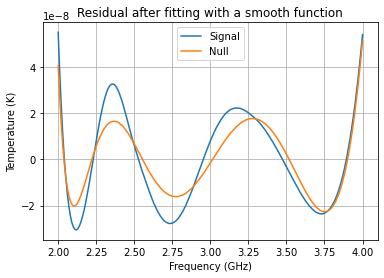

Working for 1d total wobble: 15.0 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


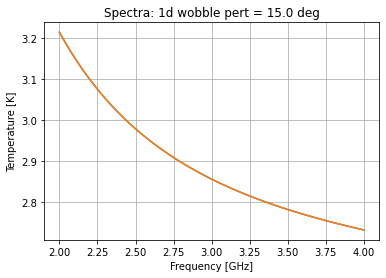

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 236
         Function evaluations: 471
 
chisq1 =  6.188843894365855e-05
2.728058970286885 -0.2729982497340194 -2.431381408524297
 
 
chisq2 =  3.0510695084610123e-06
2.723658542009568 -0.26926586094332416 -2.4194024914845116 0.12189648145706
 
 
chisq3 =  8.838026890837536e-08
2.7211176491933644 -0.2672282680806062 -2.4073188744867946 0.14119208320384952 0.11407344147843024
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1357
         Function evaluations: 2223
 
chisq4 =  2.3001697464656023e-08
2.7197586317381464 -0.26613745647704334 -2.4013141892387804 0.1583737757429895 0.13446074155720583 0.0650881101263575
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 314
         Fun

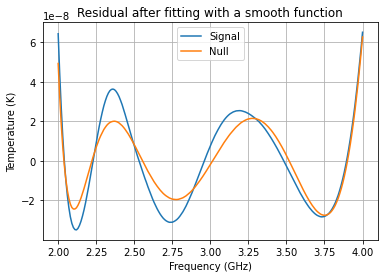

Working for 1d total wobble: 15.6 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


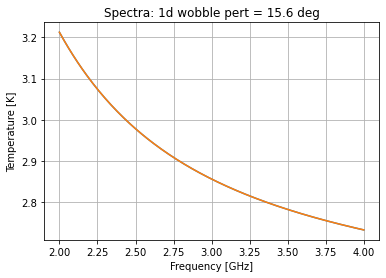

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  6.643200995005038e-05
2.728203415243825 -0.27408600874819244 -2.427045363673025
 
Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 271
         Function evaluations: 563
 
chisq2 =  3.450343003120778e-06
2.723432427963316 -0.2700324993304454 -2.413982241625172 0.13140285277671493
 
 
chisq3 =  9.988755883464239e-08
2.7204422855258334 -0.2676310193129664 -2.3998111298605376 0.15439496940400044 0.1310138539767846
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1749
         Function evaluations: 2888
 
chisq4 =  2.6338538478505886e-08
2.7186344479123643 -0.26617927068350467 -2.3918415663318306 0.1768964216319522 0.15877577685074012 0.07991903780773421
 
 
chisq5 =  2.6337861857376933e-08
2.718634223457043 -0.2661790902142353 -2.3918406481954815 0.1769010553888094 0.15

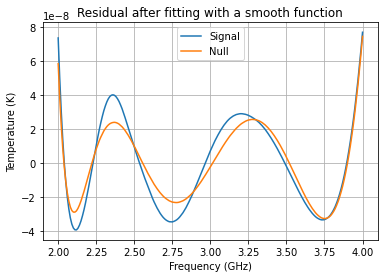

Working for 1d total wobble: 16.2 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


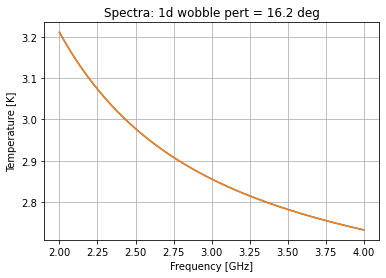

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  7.128853254988846e-05
2.728355055857802 -0.2751734414845817 -2.42280527390654
 
 
chisq2 =  3.884100909751325e-06
2.7231822160116135 -0.27077128894987673 -2.4085582486024886 0.14162813647031605
 
 
chisq3 =  1.1248180879832495e-07
2.719663952329752 -0.26794174780440255 -2.391947844414025 0.1690369740066311 0.15009304508446356
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2265
         Function evaluations: 3602
 
chisq4 =  2.9577332818164004e-08
2.7170738545946747 -0.26586192189987434 -2.3805653944412057 0.20066528458060306 0.19095558300610166 0.10315138232614798
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 335
         Function evaluations: 739
 
chisq5 =  2.9577008646218588e-08
2.7170738713246605 -0.2658619349763266 -2.380565493473833 0.2006654659842529 0.

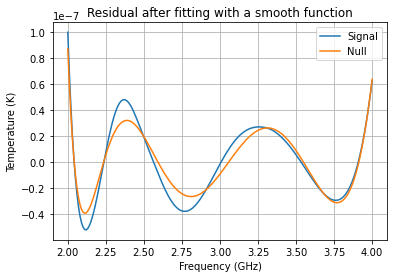

Working for 1d total wobble: 16.8 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


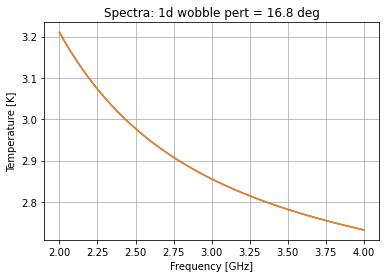

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000076
         Iterations: 252
         Function evaluations: 500
 
chisq1 =  7.646911499728409e-05
2.728514056093768 -0.2762605618443431 -2.4186634328627505
 
 
chisq2 =  4.354167346844365e-06
2.7229059179847024 -0.2714803322283643 -2.403124762634138 0.1526088068476042
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 474
         Function evaluations: 918
 
chisq3 =  1.2651840209582076e-07
2.718761479572068 -0.2681430777592093 -2.3836412263102167 0.18534151413489072 0.17167170372001778
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8031
         Function evaluations: 12307
 
chisq4 =  2.2467908232819377e-08
2.711789563866401 -0.2625651569499017 -2.3532772083185485 0.2667690066500288 0.2888743295028808

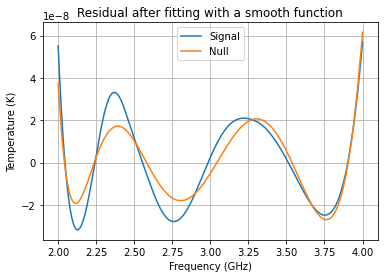

Working for 1d total wobble: 17.4 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


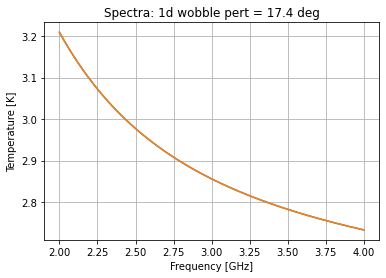

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  8.198465833941481e-05
2.7286805698853396 -0.27734737609256976 -2.414622074788443
 
 
chisq2 =  4.86244340122051e-06
2.7226013927219914 -0.2721576041759708 -2.3976753556359434 0.16438246335963982
 
 
chisq3 =  1.4258265938185075e-07
2.717705756813524 -0.2682112853080935 -2.374770127974303 0.20360953469823376 0.19623919560429864
 
 
chisq4 =  6.271165651705233e-08
2.71359914906282 -0.2649165598628512 -2.3568603946132285 0.25172836414734856 0.26389256364024505 0.127032973375644
 
 
chisq5 =  3.552874676150428e-08
2.713628309366094 -0.26493969165988546 -2.3570070818766533 0.25193465034304885 0.25810963687387456 0.14767059774873792 -0.030237861746494565
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1874
         Function evaluations: 3020
 
chisq6 =  3.137052912022445e-08
2.7136049169462177 -0.26492097844341644 -2.35690

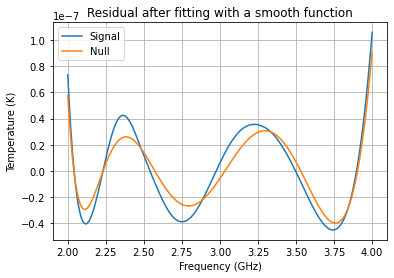

Working for 1d total wobble: 18.0 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


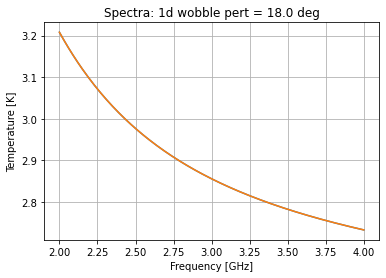

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  8.784585057230482e-05
2.72885475198468 -0.27843389608428976 -2.410683426346097
 
Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 287
         Function evaluations: 580
 
chisq2 =  5.410913791665742e-06
2.7222663032764114 -0.27280091717339494 -2.392202760590929 0.17698851819026212
 
 
chisq3 =  1.6166018477010657e-07
2.7164546088906936 -0.2681122266542337 -2.3651586866065895 0.22426946380761126 0.22449658496884395
 
 
chisq4 =  1.0960719677904204e-07
2.7125140700662063 -0.26495103107391454 -2.3480323304248154 0.269678992062214 0.2899053413527108 0.10868151835861696
 
 
chisq5 =  4.159386870913051e-08
2.712510493529698 -0.2649478745561301 -2.348055087572523 0.2707564115965582 0.2797031281100356 0.15046192397309524 -0.059152497286104354
 
Optimization terminated successfully.
         Current function value: 0.000000
    

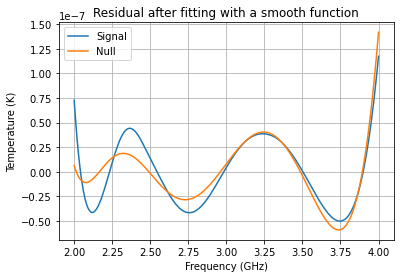

Working for 1d total wobble: 18.599999999999998 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


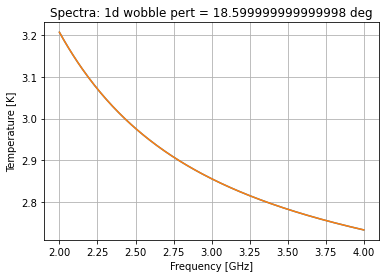

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
Optimization terminated successfully.
         Current function value: 0.000094
         Iterations: 242
         Function evaluations: 487
 
chisq1 =  9.406316090729748e-05
2.7290367501100348 -0.27952013019129296 -2.4068496531148655
 
 
chisq2 =  6.001654504175761e-06
2.7218981200756067 -0.27340792518280305 -2.3866988536127396 0.190467652259274
 
 
chisq3 =  1.854996563288537e-07
2.71494237163378 -0.26779306608919207 -2.3545329378451787 0.24797868970084666 0.25752615949068886
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2210
         Function evaluations: 3560
 
chisq4 =  1.6086759562323138e-07
2.7121782303464013 -0.26557485871698105 -2.342551923675198 0.2794168495360554 0.30339679933817615 0.06940235545114701
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 884
         

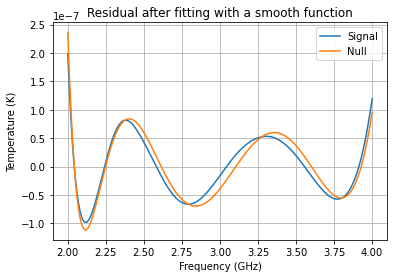

Working for 1d total wobble: 19.2 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


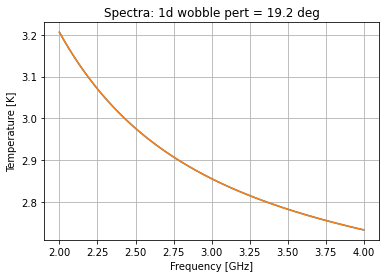

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  0.0001006468342017812
2.7292267127932264 -0.28060608714380103 -2.4031229643688787
 
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 296
         Function evaluations: 600
 
chisq2 =  6.636841648495123e-06
2.721494057721327 -0.27397607223353493 -2.3811544184992712 0.20486279697718665
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 601
         Function evaluations: 1094
 
chisq3 =  2.1751413773232027e-07
2.713055596706498 -0.2671630283271005 -2.342419916540666 0.27586013220730815 0.29718345290778386
 
 
chisq4 =  2.1255944873874884e-07
2.7117787801315796 -0.2661384853617197 -2.33690471515521 0.29016098527232104 0.3183595794427599 0.028468693509238974
 
 
chisq5 =  1.5746725489284423e-07
2.7118452931345236 -0.26619159446005747 -2.337215942340553 0.29006533199845774 0

/tmp/ipykernel_5921/1517745540.py:556: RuntimeWarning: Maximum number of iterations has been exceeded.
  p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)


 
chisq10 =  1.5741040433203074e-07
2.711845417232743 -0.26619169106471413 -2.3372166333859936 0.2900624542030035 0.3110660725949731 0.051686803677092566 -0.03438080364441101 5.675323194354279e-08 3.8832335511201185e-13 1.7128961621026645e-08 9.728639663468237e-09 0.0003927339899271419
 
[]
Limits in index:  0 200
201
201
 
chisq1 =  0.00010064958227249112
2.7292266940991077 -0.28060643238491756 -2.4031237844956554
 
 
chisq2 =  6.637088965630299e-06
2.7214938131125517 -0.27397621980814635 -2.3811545613813263 0.20486872769993614
 
 
chisq3 =  2.1721035439907127e-07
2.7130548174533544 -0.2671627447376088 -2.342417675050344 0.2758710666570103 0.29719768137417135
 
 
chisq4 =  2.1229689433101563e-07
2.7117896095139096 -0.26614750644551377 -2.3369525250375593 0.290042883899709 0.31817929171233195 0.028226743654474404
 
 
chisq5 =  1.5198262009053757e-07
2.7117185176624417 -0.26609032919806813 -2.336670391514633 0.2914908596773348 0.31286700356850705 0.056034767105237165 -0.0372286933010598

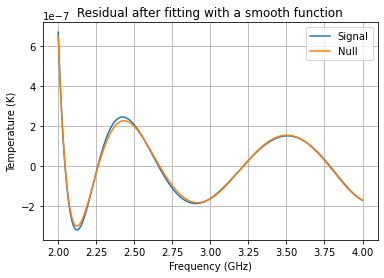

Working for 1d total wobble: 19.8 deg...
Number of pixels got:  1000
Number of pixels got:  2000
Number of pixels got:  3000


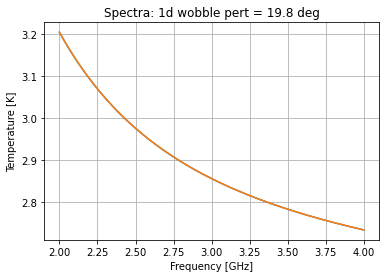

 
CAUTION: this version is hard-coded for freq range:  2.0  to  4.0  GHz
Limits in index:  0 200
201
201
 
chisq1 =  0.0001076068854931268
2.7294247883106397 -0.2816917815758072 -2.3995055419639524
 
 
chisq2 =  7.318761846809626e-06
2.721051063075266 -0.27450258344591166 -2.37555909261451 0.22021888282831545
 
 
chisq3 =  2.6561096582507284e-07
2.710561706284175 -0.2660369668833412 -2.3278519272262534 0.3101969694776418 0.3472445579678919
 
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1250
         Function evaluations: 2125
 
chisq4 =  2.639691358993435e-07
2.7113248363421354 -0.26664887229515755 -2.331133122313279 0.3018069245293148 0.3346085659813306 -0.014507810839336326
 
 
chisq5 =  2.254406069193708e-07
2.711410931798626 -0.26671787443045614 -2.3315161352653564 0.3012169071808145 0.32938601207185547 -2.3413802999866717e-07 -0.02393473769627166
 
 
chisq6 =  2.1522694028608084e-07
2.7114773870497055 -0.2667712809077197 -2.3

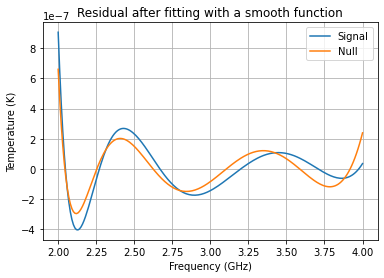

In [44]:
%matplotlib inline

ED_1d_wobble_with_sig = np.zeros(len(np.arange(0, 10, 0.3)))
ED_1d_wobble_no_sig = np.zeros(len(np.arange(0, 10, 0.3)))


for pert1 in np.arange(0, 10, 0.3):
    
    print(f"Working for 1d total wobble: {2*pert1} deg...")

    def beam_def(freq, alt, az):
    #     return float(my_interpolating_function([freq, alt, az]))
        if (alt<=0):
            return 0
        else:
            # return (math.sin((alt-pert1*(freq - 3))*PI/180)*math.sin((alt-pert1*(freq - 3))*PI/180))
            return (math.sin((alt - math.sin(az * PI/180)* pert1 * (3 - freq)) * PI/180))**2

    i=1
    while i<NPIX:           #Working on each pixel
        coords = hp.pixelfunc.pix2ang(16, i , nest = False, lonlat = True)          #Gives l and b coordinates for each pixel
        gc = SkyCoord(l = coords[0]*u.degree, b= coords[1]*u.degree, frame = 'galactic')

        #Now, the coordinates in Galactic frame is changed to equitorial frame below
        equi = gc.transform_to(AltAz(obstime = Time_in_UTC[0], location = EarthLocation(lat = latitude*u.deg, lon=longitude*u.deg , height=altitude*u.m)))
        alt = equi.alt.value
        new_alt = refraction(alt, altitude) 
        #print(new_alt)

        #Using power law relation to fit spectra of three frequency maps
        def func(xx, a):
            return (sky_408)[i-1] * np.power((xx/0.408), a) 

        xx = np.array([0.408, 1.420, 23])
        yy = np.array([sky_408[i-1], sky_1420[i-1], sky_23000[i-1]])

        popt, pcov = curve_fit(func, xx, yy)
        


        j=0
        longitudes = equi.az.value
        while j< No_of_Channels:

            cwt = beam_def(freqs[j], new_alt, longitudes)

            if (cwt>=0):     #Adding all the three intensities

                map_1 = (2*k*1e+18 * (freqs[j]**2) *sky_408[i-1]* np.power(freqs[j]/0.408, float(popt)))/ (c**2)
                

                Power_with_sig = (map_1 + CMB_Int[j] + Rec_int[j]) *(c*c/ (1e+18* freqs[j]**2)) 
                Power_no_sig = (map_1 + CMB_Int[j]) *(c*c/ (1e+18* freqs[j]**2))



                cross_real_with_sig[j] = cross_real_with_sig[j] + cwt*Power_with_sig   
                cross_real_no_sig[j] = cross_real_no_sig[j] + cwt*Power_no_sig


                sumwt_with_sig[j] = sumwt_with_sig[j]+ cwt
                sumwt_no_sig[j] = sumwt_no_sig[j]+ cwt

                final_temp_with_sig[j] = (cross_real_with_sig[j]/P_dif[j])*(T_hot-T_cold)
                final_temp_no_sig[j] = (cross_real_no_sig[j]/P_dif[j])*(T_hot-T_cold)

            j = j+1

        if (i%1000 == 0):
            print('Number of pixels got: ', i)

        i = i+1


    q=0    
    while(q< No_of_Channels):
        if sumwt_with_sig[q]>0 and sumwt_no_sig[q]>0:
            final_temp_with_sig[q] = final_temp_with_sig[q]/sumwt_with_sig[q]
            final_temp_no_sig[q] = final_temp_no_sig[q]/sumwt_no_sig[q]
        q = q+1


    cross_real_with_sig = final_temp_with_sig
    cross_real_no_sig = final_temp_no_sig

    spectra_with_sig = cross_real_with_sig
    spectra_no_sig = cross_real_no_sig

    cross_real_with_sig = [0]*No_of_Channels
    sumwt_with_sig = [0]*No_of_Channels

    cross_real_no_sig = [0]*No_of_Channels
    sumwt_no_sig = [0]*No_of_Channels



    Obs = ephem.Observer()
    t = Time(Time_in_UTC, scale='utc',location=(longitude, latitude))
    lst = t.sidereal_time('apparent')



    plt.plot(freqs, spectra_with_sig, label = "With signal")
    plt.plot(freqs, spectra_no_sig, label = "Null case")
    plt.xlabel('Frequency [GHz]')
    plt.ylabel('Temperature [K]')
    plt.title(f'Spectra: 1d wobble pert = {2*pert1} deg')
    plt.grid()
    plt.show()
    
#     hp.mollview(check_map, nest = True)
    
    while True:
        break



    #______________________________________________________________________________________________________________
    #______________________________________________________________________________________________________________
    #______________________________________________________________________________________________________________

    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.constants
    import random as rndm
    from math import exp, expm1, sqrt
    from math import factorial as mf
    from scipy.optimize import fmin
    from scipy import interpolate
    from matplotlib.backends.backend_pdf import PdfPages

    PI=scipy.constants.pi
    HH=scipy.constants.h
    KK=scipy.constants.k
    HbK=HH/KK
    HbK9=HbK*1.0e9

    X1 = 2.0
    X2 = 4.0
    print (' ')
    print ('CAUTION: this version is hard-coded for freq range: ',X1,' to ',X2,' GHz')

    X1LOG = np.log10(X1)
    X2LOG = np.log10(X2)
    XDIF = X1LOG-X2LOG

    np.set_printoptions(precision=20)



    func1 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 \
                              )

    func2 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2  \
                              )

    func3 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3  \
                              )

    func4 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4  \
                              )

    func5 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5  \
                              )

    func6 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6  \
                              )

    func7 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7  \
                              )
    func8 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7 + \
                        (p[9])*(np.log10(x)-X1LOG)**8)

    func9 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7 + \
                        (p[9])*(np.log10(x)-X1LOG)**8 + \
                            (p[10])*(np.log10(x)-X1LOG)**9)

    func10 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7 + \
                        (p[9])*(np.log10(x)-X1LOG)**8 + \
                            (p[10])*(np.log10(x)-X1LOG)**9+ \
                        (p[11])*(np.log10(x)-X1LOG)**10)	

    func11 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7 + \
                        (p[9])*(np.log10(x)-X1LOG)**8 + \
                            (p[10])*(np.log10(x)-X1LOG)**9+ \
                        (p[11])*(np.log10(x)-X1LOG)**10+ \
                        (p[12])*(np.log10(x)-X1LOG)**11)

    func12 = lambda p, x: (HbK9*x)/( np.exp( HbK9*x/(10.0**p[0]) )-1.0 ) + \
                        10.0**( \
                        (p[1]) + \
                        (p[2])*(np.log10(x)-X1LOG)**1 + \
                        (p[3])*(np.log10(x)-X1LOG)**2 + \
                        (p[4])*(np.log10(x)-X1LOG)**3 + \
                        (p[5])*(np.log10(x)-X1LOG)**4 + \
                        (p[6])*(np.log10(x)-X1LOG)**5 + \
                        (p[7])*(np.log10(x)-X1LOG)**6 + \
                        (p[8])*(np.log10(x)-X1LOG)**7 + \
                        (p[9])*(np.log10(x)-X1LOG)**8 + \
                            (p[10])*(np.log10(x)-X1LOG)**9+ \
                        (p[11])*(np.log10(x)-X1LOG)**10+ \
                        (p[12])*(np.log10(x)-X1LOG)**11+ \
                        (p[13])*(np.log10(x)-X1LOG)**12)	

    # define the function to be minimized by scipy.optimize.fmin
    chisq1 = lambda p, x, y: sqrt(((func1(p,x)-y)**2).sum()/float(len(x)))

    chisq2 = lambda p, x, y: sqrt(((func2(p,x)-y)**2).sum()/float(len(x)))

    def chisq3 (p, x, y):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func3(p,x)-y)**2).sum()/float(len(x)))

    def chisq4 (p, x, y ):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func4(p,x)-y)**2).sum()/float(len(x)))

    def chisq5 (p, x, y ):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func5(p,x)-y)**2).sum()/float(len(x)))

    def chisq6 (p, x, y ):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
            (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
            (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2
        k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                or k5[i+1]*k5[i] < 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func6(p,x)-y)**2).sum()/float(len(x)))

    def chisq7 (p, x, y):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
            (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
            (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
            (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3
        k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
            (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2
        k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func7(p,x)-y)**2).sum()/float(len(x)))

    def chisq8 (p, x, y):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
            (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
            (mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
            (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
            (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
            (mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4
        k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
            (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3
        k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) +  (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2
        k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func8(p,x)-y)**2).sum()/float(len(x)))

    def chisq9 (p, x, y):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
            (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
            (mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
            (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
            (mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
            (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
            (mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5
        k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
            (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
            (mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4
        k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
               (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3
        k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2
        k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
                or k8[i+1]*k8[i]< 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func9(p,x)-y)**2).sum()/float(len(x)))

    def chisq10 (p, x, y):
        k2 = (mf(2)/mf(0))*p[3] + (mf(3)/mf(1))*p[4]*(np.log10(x)-X1LOG) + \
            (mf(4)/mf(2))*p[5]*(np.log10(x)-X1LOG)**2 + (mf(5)/mf(3))*p[6]*(np.log10(x)-X1LOG)**3 + \
            (mf(6)/mf(4))*p[7]*(np.log10(x)-X1LOG)**4 + (mf(7)/mf(5))*p[8]*(np.log10(x)-X1LOG)**5 + \
            (mf(8)/mf(6))*p[9]*(np.log10(x)-X1LOG)**6 + (mf(9)/mf(7))*p[10]*(np.log10(x)-X1LOG)**7 + \
            (mf(10)/mf(8))*p[11]*(np.log10(x)-X1LOG)**8
        k3 = (mf(3)/mf(0))*p[4] + (mf(4)/mf(1))*p[5]*(np.log10(x)-X1LOG) + \
            (mf(5)/mf(2))*p[6]*(np.log10(x)-X1LOG)**2 + (mf(6)/mf(3))*p[7]*(np.log10(x)-X1LOG)**3 + \
            (mf(7)/mf(4))*p[8]*(np.log10(x)-X1LOG)**4 + (mf(8)/mf(5))*p[9]*(np.log10(x)-X1LOG)**5 + \
            (mf(9)/mf(6))*p[10]*(np.log10(x)-X1LOG)**6 + (mf(10)/mf(7))*p[11]*(np.log10(x)-X1LOG)**7
        k4 = (mf(4)/mf(0))*p[5] + (mf(5)/mf(1))*p[6]*(np.log10(x)-X1LOG) + \
            (mf(6)/mf(2))*p[7]*(np.log10(x)-X1LOG)**2 + (mf(7)/mf(3))*p[8]*(np.log10(x)-X1LOG)**3 + \
            (mf(8)/mf(4))*p[9]*(np.log10(x)-X1LOG)**4 + (mf(9)/mf(5))*p[10]*(np.log10(x)-X1LOG)**5 + \
            (mf(10)/mf(6))*p[11]*(np.log10(x)-X1LOG)**6
        k5 = (mf(5)/mf(0))*p[6] + (mf(6)/mf(1))*p[7]*(np.log10(x)-X1LOG) + \
            (mf(7)/mf(2))*p[8]*(np.log10(x)-X1LOG)**2 + (mf(8)/mf(3))*p[9]*(np.log10(x)-X1LOG)**3 + \
            (mf(9)/mf(4))*p[10]*(np.log10(x)-X1LOG)**4 + (mf(10)/mf(5))*p[11]*(np.log10(x)-X1LOG)**5
        k6 = (mf(6)/mf(0))*p[7] + (mf(7)/mf(1))*p[8]*(np.log10(x)-X1LOG) + (mf(8)/mf(2))*p[9]*(np.log10(x)-X1LOG)**2 + \
               (mf(9)/mf(3))*p[10]*(np.log10(x)-X1LOG)**3 + (mf(10)/mf(4))*p[11]*(np.log10(x)-X1LOG)**4
        k7 = (mf(7)/mf(0))*p[8] + (mf(8)/mf(1))*p[9]*(np.log10(x)-X1LOG) + (mf(9)/mf(2))*p[10]*(np.log10(x)-X1LOG)**2 + \
            (mf(10)/mf(3))*p[11]*(np.log10(x)-X1LOG)**3
        k8 = (mf(8)/mf(0))*p[9] + (mf(9)/mf(1))*p[10]*(np.log10(x)-X1LOG) + (mf(10)/mf(2))*p[11]*(np.log10(x)-X1LOG)**2
        k9 = (mf(9)/mf(0))*p[10] + (mf(10)/mf(1))*p[11]*(np.log10(x)-X1LOG)
        for i in range (len(x)-1):
            if k2[i+1]*k2[i] < 0.0 or k3[i+1]*k3[i] < 0.0 or k4[i+1]*k4[i] < 0.0 \
                or k5[i+1]*k5[i] < 0.0 or k6[i+1]*k6[i] < 0.0 or k7[i+1]*k7[i]< 0.0 \
                or k8[i+1]*k8[i]< 0.0 or k9[i+1]*k9[i]< 0.0: 
                return 100.0+min(i,len(x)-i)
        return sqrt(((func10(p,x)-y)**2).sum()/float(len(x)))


    residuals = []
    x0 = freqs
    #print(x0)
    x0 = np.asfarray(x0)
    x0log = np.log10(x0)


    low=1.0
    high=5.0


    i_low=0
    i_high=len(x0)
    for i in range(0, len(x0)):
        if x0[i]<=low:
            i_low=i
        if x0[i]<=high:
            i_high=i
    print("Limits in index: ",i_low,i_high)
    x1=x0[i_low:i_high+1]   #Check the +1 term
    x1log = np.log10(x1)
    X1=(x1log[0])
    print(x1.size)

    y1 = np.array(spectra_with_sig)
    print(y1.size)
    y1log = np.log10(y1)



    p12 = np.poly1d(np.polyfit(x1log, y1log, 10))
    yfit_poly = p12(x1log)
    yres_poly = (10.0**yfit_poly) - y1
    #plt.figure()
    #plt.grid()
    #plt.xlabel('Freq [MHz]')
    #plt.ylabel('res Temp [K]')
    #plt.plot(x1*1.0e3,yres_poly,lw=2)
    #plt.plot(np.log10(nu),np.log10(T[pix]),'ro')
    #plt.title('Polyo10 residual spec %s'%(i))
    # plt.show()
    #pdf.savefig()
    #plt.close()
    # Initial guess for optimization				
    p00 = [np.log10(3.0),1.0,-2.5] 

    p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq1, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq1, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    current_chisq = chisq1(p1,x1,y1)
    print (" ")
    print ("chisq1 = ",current_chisq)
    print (10.0**p1[0], p1[1], p1[2])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],0.0] 
    p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq2, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq2, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq2(p1,x1,y1)
    print (" ")
    print ("chisq2 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],0.0]
    p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq3, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq3, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq3(p1,x1,y1)
    print (" ")
    print ("chisq3 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],0.0]
    p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq4, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq4, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq4(p1,x1,y1)
    print (" ")
    print ("chisq4 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],0.0]
    p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq5, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq5, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq5(p1,x1,y1)
    print (" ")
    print ("chisq5 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],0.0]
    p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq6, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq6, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq6(p1,x1,y1)
    print (" ")
    print ("chisq6 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],0.0]
    p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq7, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq7, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq7(p1,x1,y1)
    print (" ")
    print ("chisq7 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],0.0]
    p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq8(p1,x1,y1)
    print (" ")
    print ("chisq8 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9])

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],0.0]
    p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq9(p1,x1,y1)
    print (" ")
    print ("chisq9 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10])

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],p1[10],0.0]
    p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq10(p1,x1,y1)
    print (" ")
    print ("chisq10 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10],p1[11])
    print (" ")

    yfit = func10(p1,x1)
    yres = y1 - yfit
    #residuals.append(yres) 
    # scale = 0.03/chisq12(p1,x1,y1)
    # y2 = yfit + scale*(1.0e5**yres)
    yfitlog=np.log10(yfit)

    residuals = np.asfarray(residuals)
    print(residuals)

    sp1_with_sig = y1 -yfit


    #_____________________________________________________________________________________________________________
    #_____________________________________________________________________________________________________________
    #_____________________________________________________________________________________________________________



    residuals = []
    x0 = freqs
    #print(x0)
    x0 = np.asfarray(x0)
    x0log = np.log10(x0)


    low=1.0
    high=5.0


    i_low=0
    i_high=len(x0)
    for i in range(0, len(x0)):
        if x0[i]<=low:
            i_low=i
        if x0[i]<=high:
            i_high=i
    print("Limits in index: ",i_low,i_high)
    x1=x0[i_low:i_high+1]   #Check the +1 term
    x1log = np.log10(x1)
    X1=(x1log[0])
    print(x1.size)

    y1 = np.array(spectra_no_sig)
    print(y1.size)
    y1log = np.log10(y1)



    p12 = np.poly1d(np.polyfit(x1log, y1log, 10))
    yfit_poly = p12(x1log)
    yres_poly = (10.0**yfit_poly) - y1
    #plt.figure()
    #plt.grid()
    #plt.xlabel('Freq [MHz]')
    #plt.ylabel('res Temp [K]')
    #plt.plot(x1*1.0e3,yres_poly,lw=2)
    #plt.plot(np.log10(nu),np.log10(T[pix]),'ro')
    #plt.title('Polyo10 residual spec %s'%(i))
    # plt.show()
    #pdf.savefig()
    #plt.close()
    # Initial guess for optimization				
    p00 = [np.log10(3.0),1.0,-2.5] 

    p1 = fmin(chisq1, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq1, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq1, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    current_chisq = chisq1(p1,x1,y1)
    print (" ")
    print ("chisq1 = ",current_chisq)
    print (10.0**p1[0], p1[1], p1[2])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],0.0] 
    p1 = fmin(chisq2, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq2, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq2, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq2(p1,x1,y1)
    print (" ")
    print ("chisq2 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],0.0]
    p1 = fmin(chisq3, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq3, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq3, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq3(p1,x1,y1)
    print (" ")
    print ("chisq3 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],0.0]
    p1 = fmin(chisq4, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq4, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq4, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq4(p1,x1,y1)
    print (" ")
    print ("chisq4 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],0.0]
    p1 = fmin(chisq5, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq5, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq5, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq5(p1,x1,y1)
    print (" ")
    print ("chisq5 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],0.0]
    p1 = fmin(chisq6, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq6, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq6, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq6(p1,x1,y1)
    print (" ")
    print ("chisq6 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],0.0]
    p1 = fmin(chisq7, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p2 = fmin(chisq7, p1, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
#		p1 = fmin(chisq7, p2, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000)  
    final_chisq = chisq7(p1,x1,y1)
    print (" ")
    print ("chisq7 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8])
    print (" ")

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],0.0]
    p1 = fmin(chisq8, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq8(p1,x1,y1)
    print (" ")
    print ("chisq8 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9])

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],0.0]
    p1 = fmin(chisq9, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq9(p1,x1,y1)
    print (" ")
    print ("chisq9 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10])

    p00 = [p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8],p1[9],p1[10],0.0]
    p1 = fmin(chisq10, p00, args=(x1,y1),ftol=1.0e-20,maxiter=50000, maxfun=100000) 
    final_chisq = chisq10(p1,x1,y1)
    print (" ")
    print ("chisq10 = ",final_chisq)
    print (10.0**p1[0], p1[1], p1[2], p1[3], p1[4], p1[5], p1[6], p1[7], p1[8], p1[9],p1[10],p1[11])
    print (" ")

    yfit = func10(p1,x1)
    yres = y1 - yfit
    #residuals.append(yres) 
    # scale = 0.03/chisq12(p1,x1,y1)
    # y2 = yfit + scale*(1.0e5**yres)
    yfitlog=np.log10(yfit)

    residuals = np.asfarray(residuals)
    print(residuals)

    sp1_no_sig = y1 -yfit


    np.savetxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_13hlst/Sig_Total_wobble: {round(2*pert1, 2)} deg", sp1_with_sig)
    np.savetxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_13hlst/Null_Total_wobble: {round(2*pert1, 2)} deg", sp1_no_sig)

    plt.plot(freqs, sp1_with_sig, label = "Signal")
    plt.plot(freqs, sp1_no_sig, label = "Null")
    plt.legend()
    plt.grid()
    plt.ylabel('Temperature (K)')
    plt.xlabel('Frequency (GHz)')
    plt.title('Residual after fitting with a smooth function')
    plt.show()
    
    ED_1d_wobble_with_sig[round(pert1 / 0.3)] = scipy.spatial.distance.euclidean(sp1_with_sig, np.loadtxt("Final_Template Bank/P0_no_noise")) 
    ED_1d_wobble_no_sig[round(pert1 / 0.3)] = scipy.spatial.distance.euclidean(sp1_no_sig, np.loadtxt("Final_Template Bank/P0_no_noise")) 


np.savetxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_13hlst/ED_1d_wobble_with_sig", ED_1d_wobble_with_sig)
np.savetxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_13hlst/ED_1d_wobble_no_sig", ED_1d_wobble_no_sig)


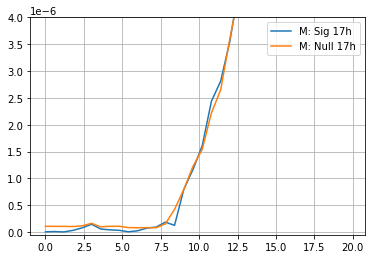

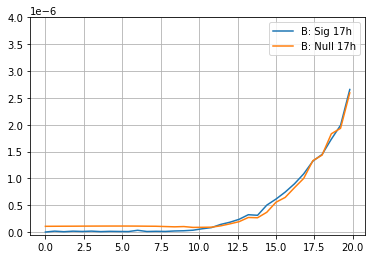

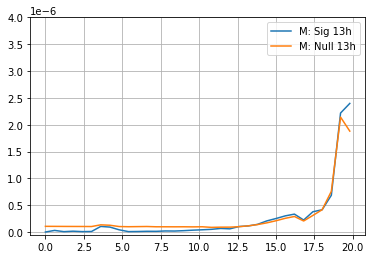

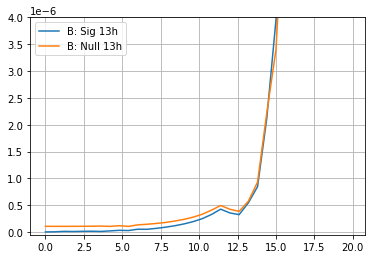

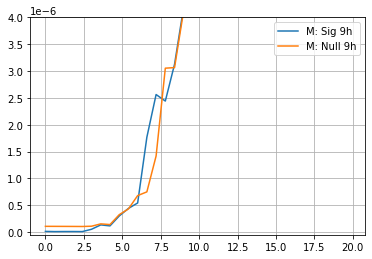

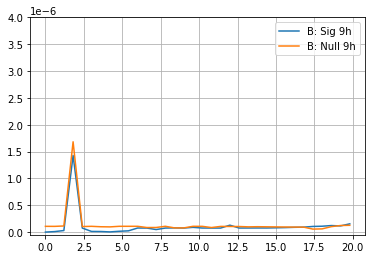

In [89]:
plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_17hlst/ED_1d_wobble_with_sig"), label = "M: Sig 17h")
plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_17hlst/ED_1d_wobble_no_sig"), label = "M: Null 17h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()

plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_17hlst/ED_1d_wobble_with_sig"), label = "B: Sig 17h")
plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_17hlst/ED_1d_wobble_no_sig"), label = "B: Null 17h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()

plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_13hlst/ED_1d_wobble_with_sig"), label = "M: Sig 13h")
plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_13hlst/ED_1d_wobble_no_sig"), label = "M: Null 13h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()

plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_13hlst/ED_1d_wobble_with_sig"), label = "B: Sig 13h")
plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_13hlst/ED_1d_wobble_no_sig"), label = "B: Null 13h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()

plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_9hlst/ED_1d_wobble_with_sig"), label = "M: Sig 9h")
plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_9hlst/ED_1d_wobble_no_sig"), label = "M: Null 9h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()

plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_9hlst/ED_1d_wobble_with_sig"), label = "B: Sig 9h")
plt.plot(2*np.arange(0, 10, 0.3), np.loadtxt("Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_9hlst/ED_1d_wobble_no_sig"), label = "B: Null 9h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()


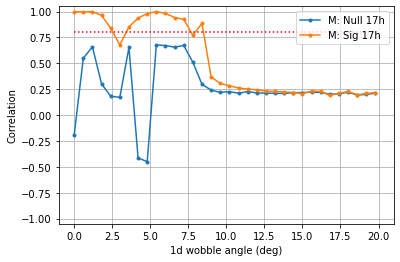

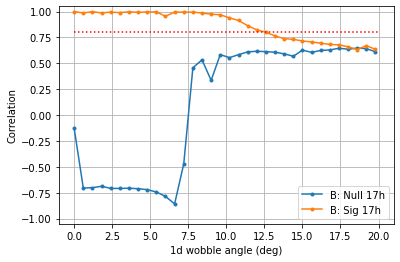

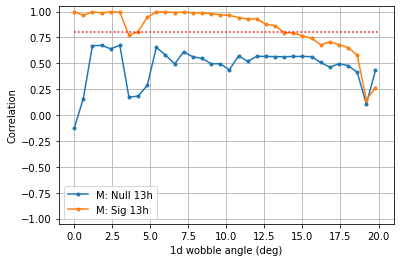

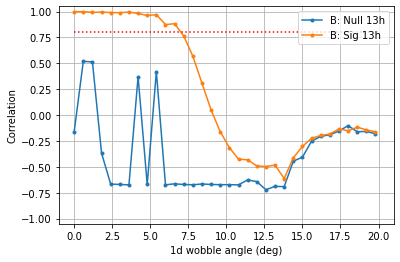

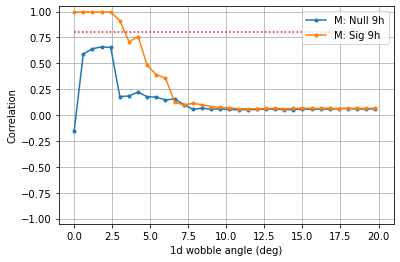

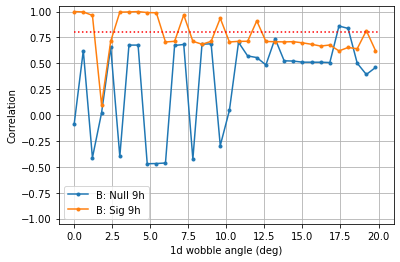

In [108]:
import scipy

corr_array_M_17h_sig = np.zeros(34)
corr_array_M_17h_null = np.zeros(34)
corr_array_B_17h_sig = np.zeros(34)
corr_array_B_17h_null = np.zeros(34)
corr_array_M_13h_sig = np.zeros(34)
corr_array_M_13h_null = np.zeros(34)
corr_array_B_13h_sig = np.zeros(34)
corr_array_B_13h_null = np.zeros(34)
corr_array_M_9h_sig = np.zeros(34)
corr_array_M_9h_null = np.zeros(34)
corr_array_B_9h_sig = np.zeros(34)
corr_array_B_9h_null = np.zeros(34)


for i in range(0,34):
    pert1 = np.arange(0, 10, 0.3)[i]
    corr_array_M_17h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_17hlst/Sig_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_M_17h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_17hlst/Null_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_B_17h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_17hlst/Sig_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_B_17h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_17hlst/Null_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    
    corr_array_M_13h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_13hlst/Sig_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_M_13h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_13hlst/Null_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic   
    corr_array_B_13h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_13hlst/Sig_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_B_13h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_13hlst/Null_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic    
    
    corr_array_M_9h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_9hlst/Sig_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_M_9h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Murchison_9hlst/Null_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_B_9h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_9hlst/Sig_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_B_9h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_wobble_fn/1d_w_Bangalore_9hlst/Null_Total_wobble: {round(2*pert1, 2)} deg"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic

    
plt.plot(2*np.arange(0, 10, 0.3), corr_array_M_17h_null, label = "M: Null 17h", marker = 'o', markersize = 3)
plt.plot(2*np.arange(0, 10, 0.3), corr_array_M_17h_sig, label = "M: Sig 17h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d wobble angle (deg)")
plt.hlines(0.8, xmin = 0, xmax = 20, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

plt.plot(2*np.arange(0, 10, 0.3), corr_array_B_17h_null, label = "B: Null 17h", marker = 'o', markersize = 3)
plt.plot(2*np.arange(0, 10, 0.3), corr_array_B_17h_sig, label = "B: Sig 17h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d wobble angle (deg)")
plt.hlines(0.8, xmin = 0, xmax = 20, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

plt.plot(2*np.arange(0, 10, 0.3), corr_array_M_13h_null, label = "M: Null 13h", marker = 'o', markersize = 3)
plt.plot(2*np.arange(0, 10, 0.3), corr_array_M_13h_sig, label = "M: Sig 13h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d wobble angle (deg)")
plt.hlines(0.8, xmin = 0, xmax = 20, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

plt.plot(2*np.arange(0, 10, 0.3), corr_array_B_13h_null, label = "B: Null 13h", marker = 'o', markersize = 3)
plt.plot(2*np.arange(0, 10, 0.3), corr_array_B_13h_sig, label = "B: Sig 13h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d wobble angle (deg)")
plt.hlines(0.8, xmin = 0, xmax = 20, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

plt.plot(2*np.arange(0, 10, 0.3), corr_array_M_9h_null, label = "M: Null 9h", marker = 'o', markersize = 3)
plt.plot(2*np.arange(0, 10, 0.3), corr_array_M_9h_sig, label = "M: Sig 9h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d wobble angle (deg)")
plt.hlines(0.8, xmin = 0, xmax = 20, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

plt.plot(2*np.arange(0, 10, 0.3), corr_array_B_9h_null, label = "B: Null 9h", marker = 'o', markersize = 3)
plt.plot(2*np.arange(0, 10, 0.3), corr_array_B_9h_sig, label = "B: Sig 9h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d wobble angle (deg)")
plt.hlines(0.8, xmin = 0, xmax = 20, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

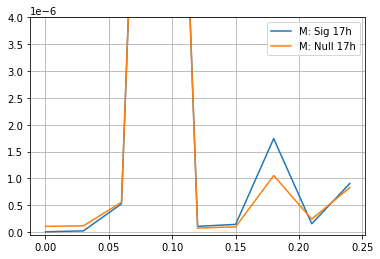

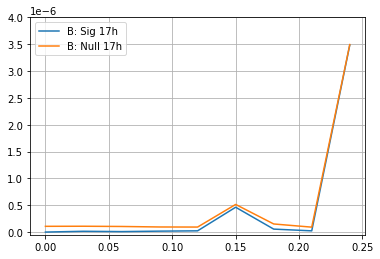

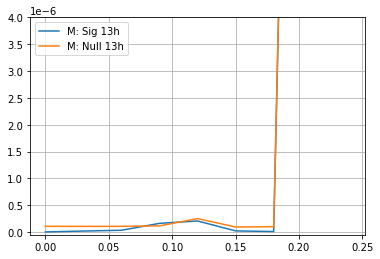

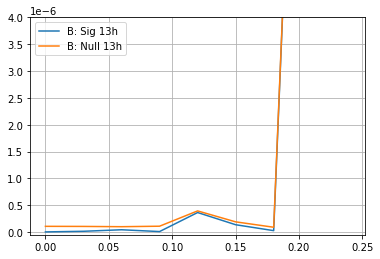

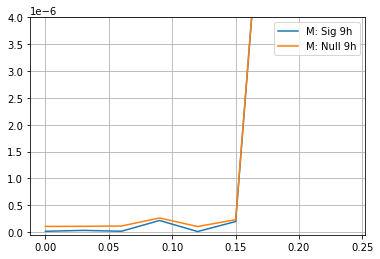

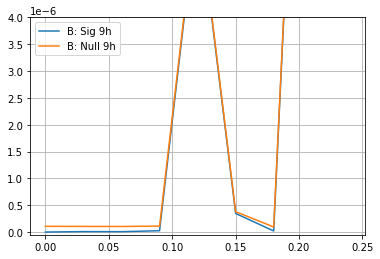

In [103]:
plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_17hlst/ED_1d_stretch_with_sig"), label = "M: Sig 17h")
plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_17hlst/ED_1d_stretch_no_sig"), label = "M: Null 17h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()

plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_17hlst/ED_1d_stretch_with_sig"), label = "B: Sig 17h")
plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_17hlst/ED_1d_stretch_no_sig"), label = "B: Null 17h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()

plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_13hlst/ED_1d_stretch_with_sig"), label = "M: Sig 13h")
plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_13hlst/ED_1d_stretch_no_sig"), label = "M: Null 13h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()

plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_13hlst/ED_1d_stretch_with_sig"), label = "B: Sig 13h")
plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_13hlst/ED_1d_stretch_no_sig"), label = "B: Null 13h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()

plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_9hlst/ED_1d_stretch_with_sig"), label = "M: Sig 9h")
plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_9hlst/ED_1d_stretch_no_sig"), label = "M: Null 9h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()

plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_9hlst/ED_1d_stretch_with_sig"), label = "B: Sig 9h")
plt.plot(np.arange(0, 0.25, 0.03), np.loadtxt("Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_9hlst/ED_1d_stretch_no_sig"), label = "B: Null 9h")
plt.legend()
plt.ylim([-5e-8, 4e-6])
plt.grid()
plt.show()


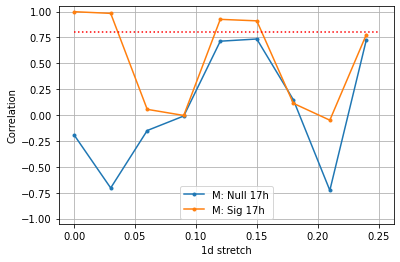

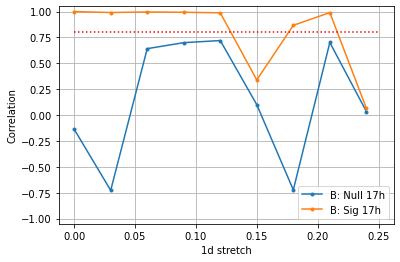

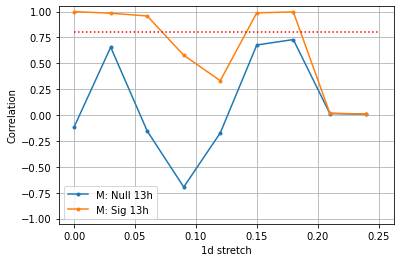

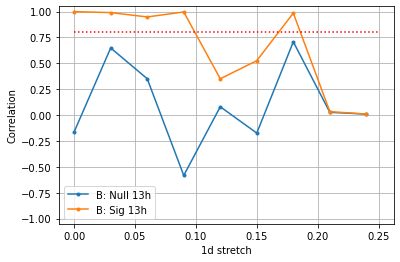

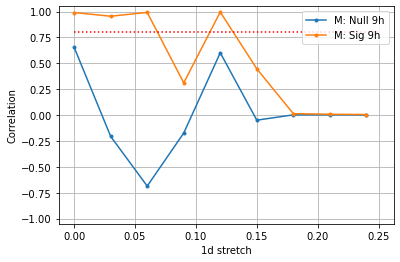

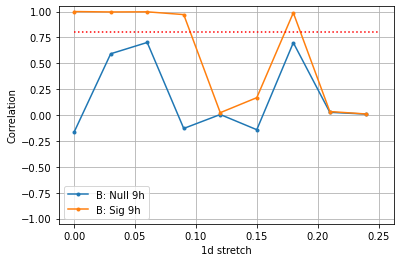

In [107]:
import scipy

corr_array_M_17h_sig = np.zeros(9)
corr_array_M_17h_null = np.zeros(9)
corr_array_B_17h_sig = np.zeros(9)
corr_array_B_17h_null = np.zeros(9)
corr_array_M_13h_sig = np.zeros(9)
corr_array_M_13h_null = np.zeros(9)
corr_array_B_13h_sig = np.zeros(9)
corr_array_B_13h_null = np.zeros(9)
corr_array_M_9h_sig = np.zeros(9)
corr_array_M_9h_null = np.zeros(9)
corr_array_B_9h_sig = np.zeros(9)
corr_array_B_9h_null = np.zeros(9)


for i in range(0,9):
    pert2 = np.arange(0, 0.25, 0.03)[i]
    corr_array_M_17h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_17hlst/Sig_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_M_17h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_17hlst/Null_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_B_17h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_17hlst/Sig_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_B_17h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_17hlst/Null_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    
    corr_array_M_13h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_13hlst/Sig_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_M_13h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_13hlst/Null_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic   
    corr_array_B_13h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_13hlst/Sig_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_B_13h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_13hlst/Null_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic    
    
    corr_array_M_9h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_9hlst/Sig_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_M_9h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Murchison_9hlst/Null_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_B_9h_sig[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_9hlst/Sig_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic
    corr_array_B_9h_null[i] = (scipy.stats.pearsonr(np.loadtxt(f"Final_Template Bank/Correct_stretch_fn/1d_s_Bangalore_9hlst/Null_Total_stretch: {round(pert2, 2)}"), np.loadtxt("Final_Template Bank/P0_no_noise"))).statistic

    
plt.plot(np.arange(0, 0.25, 0.03), corr_array_M_17h_null, label = "M: Null 17h", marker = 'o', markersize = 3)
plt.plot(np.arange(0, 0.25, 0.03), corr_array_M_17h_sig, label = "M: Sig 17h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d stretch")
plt.hlines(0.8, xmin = 0, xmax = 0.25, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

plt.plot(np.arange(0, 0.25, 0.03), corr_array_B_17h_null, label = "B: Null 17h", marker = 'o', markersize = 3)
plt.plot(np.arange(0, 0.25, 0.03), corr_array_B_17h_sig, label = "B: Sig 17h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d stretch")
plt.hlines(0.8, xmin = 0, xmax = 0.25, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

plt.plot(np.arange(0, 0.25, 0.03), corr_array_M_13h_null, label = "M: Null 13h", marker = 'o', markersize = 3)
plt.plot(np.arange(0, 0.25, 0.03), corr_array_M_13h_sig, label = "M: Sig 13h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d stretch")
plt.hlines(0.8, xmin = 0, xmax = 0.25, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

plt.plot(np.arange(0, 0.25, 0.03), corr_array_B_13h_null, label = "B: Null 13h", marker = 'o', markersize = 3)
plt.plot(np.arange(0, 0.25, 0.03), corr_array_B_13h_sig, label = "B: Sig 13h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d stretch")
plt.hlines(0.8, xmin = 0, xmax = 0.25, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

plt.plot(np.arange(0, 0.25, 0.03), corr_array_M_9h_null, label = "M: Null 9h", marker = 'o', markersize = 3)
plt.plot(np.arange(0, 0.25, 0.03), corr_array_M_9h_sig, label = "M: Sig 9h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d stretch")
plt.hlines(0.8, xmin = 0, xmax = 0.25, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()

plt.plot(np.arange(0, 0.25, 0.03), corr_array_B_9h_null, label = "B: Null 9h", marker = 'o', markersize = 3)
plt.plot(np.arange(0, 0.25, 0.03), corr_array_B_9h_sig, label = "B: Sig 9h", marker = 'o', markersize = 3)
plt.ylabel("Correlation")
plt.xlabel("1d stretch")
plt.hlines(0.8, xmin = 0, xmax = 0.25, color = 'red', linestyles=':')
plt.legend()
plt.grid()
plt.ylim(-1.05,1.05)
plt.show()